### TASK_01
#### Coding Assignment Task # 1
- Dataset: IEDGAR SEC filings (public data) -
- https://huggingface.co/datasets/eloukas/edgar-corpus
- Language: Python
- Implementation: Pyspark
- Submission: Github repository containing code + plots (jpeg).
- Expected Maximum Duration: 3 hours

Given a set of documents: create a solution that allows the end user to understand the documents in a two dimensional space and to identify outliers.
* Dataset:
- Year: 2020
- Filing type: 10K
- Sections: All
- Companies: Limit to 10.

* Steps:
1. Convert the documents to chunks,
2. Convert the chunks into embeddings,
3. Standard scale the embeddings,
4. Perform principal components analysis,
5. Apply dimensionality reduction,
6. Perform Kmeans clustering and assign chunks an cluster number.
7. Create an outlier flag.
8. Plot(s)
- Embeddings in 2 dimensions
- Colored by assigned clusters.
- Colored by outlier flag
- Colored by section number.

#### Dataset card:
This dataset card is based on the paper EDGAR-CORPUS: Billions of Tokens Make The World Go Round authored by Lefteris Loukas et.al, as published in the ECONLP 2021 workshop.
This dataset contains the annual reports of public companies from 1993-2020 from SEC EDGAR filings.
There is supported functionality to load a specific year.
Care: since this is a corpus dataset, different train/val/test splits do not have any special meaning. It's the default HF card format to have train/val/test splits.
If you wish to load specific year(s) of specific companies, you probably want to use the open-source software which generated this dataset, EDGAR-CRAWLER: https://github.com/nlpaueb/edgar-crawler.

In [1]:
# import os
import regex as re
from collections import defaultdict
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
import colorcet as cc
from scipy.spatial.distance import cdist
import datasets
import pandas as pd
import numpy as np
from functools import reduce
from collections import defaultdict

from sklearn.preprocessing import StandardScaler as sklearnScaler
from sklearn.decomposition  import PCA as sklearnPCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer
import faiss
import networkx as nx  # for connected components
import umap
from umap import UMAP
try:
    import pacmap
    has_pacmap = True
except ImportError:
    has_pacmap = False


import pyspark
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.functions import size, col, count, when, length, concat_ws, udf
from pyspark.sql.functions import explode, pandas_udf, lit, count, avg, max as spark_max, min as spark_min, length, expr
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, ArrayType, FloatType

from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.feature import StandardScaler, PCA


from transformers import AutoTokenizer
from sentence_transformers import SentenceTransformer

import torch
print(torch.cuda.is_available())

import os
os.environ['JAVA_HOME'] = r'D:\Softwares\Microsoft\jdk-17.0.15.6-hotspot'

from IPython.display import display, HTML
display(HTML("<style>div.output_scroll { height: 44em; }</style>"))


D:\Softwares\Anaconda3\envs\coding_task_venv\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
D:\Softwares\Anaconda3\envs\coding_task_venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


False


In [2]:
import sys
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [3]:
print(sys.executable)

D:\Softwares\Anaconda3\envs\coding_task_venv\python.exe


In [4]:
# Load a specific year and split
edgar_corpus_2020_raw = datasets.load_dataset("eloukas/edgar-corpus", "year_2020")

D:\Softwares\Anaconda3\envs\coding_task_venv\Lib\site-packages\datasets\load.py:1461: FutureWarning: The repository for eloukas/edgar-corpus contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/eloukas/edgar-corpus
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [5]:
edgar_corpus_2020_raw

DatasetDict({
    train: Dataset({
        features: ['filename', 'cik', 'year', 'section_1', 'section_1A', 'section_1B', 'section_2', 'section_3', 'section_4', 'section_5', 'section_6', 'section_7', 'section_7A', 'section_8', 'section_9', 'section_9A', 'section_9B', 'section_10', 'section_11', 'section_12', 'section_13', 'section_14', 'section_15'],
        num_rows: 5480
    })
    validation: Dataset({
        features: ['filename', 'cik', 'year', 'section_1', 'section_1A', 'section_1B', 'section_2', 'section_3', 'section_4', 'section_5', 'section_6', 'section_7', 'section_7A', 'section_8', 'section_9', 'section_9A', 'section_9B', 'section_10', 'section_11', 'section_12', 'section_13', 'section_14', 'section_15'],
        num_rows: 686
    })
    test: Dataset({
        features: ['filename', 'cik', 'year', 'section_1', 'section_1A', 'section_1B', 'section_2', 'section_3', 'section_4', 'section_5', 'section_6', 'section_7', 'section_7A', 'section_8', 'section_9', 'section_9A', 'sect

In [6]:
spark = SparkSession.builder \
    .appName("AIG_SEC_Filing_Analysis") \
    .master("local[8]") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .config("spark.python.worker.memory", "2g") \
    .config("spark.sql.shuffle.partitions", "50") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .config("spark.sql.execution.pyspark.udf.faulthandler.enabled", "true") \
    .config("spark.python.worker.faulthandler.enabled", "true") \
    .getOrCreate()

spark.sparkContext.setLogLevel("WARN")


# Exploratory data analysis

## Sanity Checks

In [7]:
edgar_corpus_2020_raw["train"].to_parquet("D:\\PracticeProjects\\nlp_10K_filings_EDGAR_corpus\\Data\\df.parquet")
df_train = spark.read.parquet("D:\\PracticeProjects\\nlp_10K_filings_EDGAR_corpus\\Data\\df.parquet")
print(f"No of rows: {df_train.count()} and no. of columns: {len(df_train.columns)} in Train split")

Creating parquet from Arrow format: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:10<00:00,  1.75s/ba]


No of rows: 5480 and no. of columns: 23 in Train split


In [8]:
edgar_corpus_2020_raw["validation"].to_parquet("D:\\PracticeProjects\\nlp_10K_filings_EDGAR_corpus\\Data\\df_val.parquet")
df_val = spark.read.parquet("D:\\PracticeProjects\\nlp_10K_filings_EDGAR_corpus\\Data\\df_val.parquet")
print(f"No of rows: {df_val.count()} and no. of columns: {len(df_val.columns)} in Validation split")

Creating parquet from Arrow format: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.14s/ba]


No of rows: 686 and no. of columns: 23 in Validation split


In [9]:
edgar_corpus_2020_raw["test"].to_parquet("D:\\PracticeProjects\\nlp_10K_filings_EDGAR_corpus\\Data\\df_test.parquet")
df_test = spark.read.parquet("D:\\PracticeProjects\\nlp_10K_filings_EDGAR_corpus\\Data\\df_test.parquet")
print(f"No of rows: {df_test.count()} and no. of columns: {len(df_test.columns)} in Test split")

Creating parquet from Arrow format: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.42s/ba]


No of rows: 685 and no. of columns: 23 in Test split


* No of rows: 5480 and no. of columns: 23 in Train split
* No of rows: 686 and no. of columns: 23 in Validation split
* No of rows: 685 and no. of columns: 23 in Test split

In [10]:
df_train.columns == df_val.columns == df_test.columns

True

* All the splits have same columns

In [11]:
columns = df_train.columns
null_columns ={column:df_train.filter(col(column).isNull()).count() for column in columns}
print(null_columns)
    

{'filename': 0, 'cik': 0, 'year': 0, 'section_1': 0, 'section_1A': 0, 'section_1B': 0, 'section_2': 0, 'section_3': 0, 'section_4': 0, 'section_5': 0, 'section_6': 0, 'section_7': 0, 'section_7A': 0, 'section_8': 0, 'section_9': 0, 'section_9A': 0, 'section_9B': 0, 'section_10': 0, 'section_11': 0, 'section_12': 0, 'section_13': 0, 'section_14': 0, 'section_15': 0}


In [12]:
columns = df_val.columns
null_columns ={column:df_val.filter(col(column).isNull()).count() for column in columns}
print(null_columns)

{'filename': 0, 'cik': 0, 'year': 0, 'section_1': 0, 'section_1A': 0, 'section_1B': 0, 'section_2': 0, 'section_3': 0, 'section_4': 0, 'section_5': 0, 'section_6': 0, 'section_7': 0, 'section_7A': 0, 'section_8': 0, 'section_9': 0, 'section_9A': 0, 'section_9B': 0, 'section_10': 0, 'section_11': 0, 'section_12': 0, 'section_13': 0, 'section_14': 0, 'section_15': 0}


In [13]:
columns = df_test.columns
null_columns ={column:df_val.filter(col(column).isNull()).count() for column in columns}
print(null_columns)

{'filename': 0, 'cik': 0, 'year': 0, 'section_1': 0, 'section_1A': 0, 'section_1B': 0, 'section_2': 0, 'section_3': 0, 'section_4': 0, 'section_5': 0, 'section_6': 0, 'section_7': 0, 'section_7A': 0, 'section_8': 0, 'section_9': 0, 'section_9A': 0, 'section_9B': 0, 'section_10': 0, 'section_11': 0, 'section_12': 0, 'section_13': 0, 'section_14': 0, 'section_15': 0}


* None of columns have any null or missing values in Train, Val and Test

In [14]:
### Below is the metadata definition from source repo - 
# https://github.com/lefterisloukas/edgar-crawler/blob/main/README.md

# {
#   "cik": "320193",
#   "company": "Apple Inc.",
#   "filing_type": "10-K",
#   "filing_date": "2022-10-28",
#   "period_of_report": "2022-09-24",
#   "sic": "3571",
#   "state_of_inc": "CA",
#   "state_location": "CA",
#   "fiscal_year_end": "0924",
#   "filing_html_index": "https://www.sec.gov/Archives/edgar/data/320193/0000320193-22-000108-index.html",
#   "htm_filing_link": "https://www.sec.gov/Archives/edgar/data/320193/000032019322000108/aapl-20220924.htm",
#   "complete_text_filing_link": "https://www.sec.gov/Archives/edgar/data/320193/0000320193-22-000108.txt",
#   "filename": "320193_10K_2022_0000320193-22-000108.htm",
#   "item_1": "Item 1. Business\nCompany Background\nThe Company designs, manufactures ...",
#   "item_1A": "Item 1A. Risk Factors\nThe Company’s business, reputation, results of ...",
#   "item_1B": "Item 1B. Unresolved Staff Comments\nNone.",
#   "item_1C": "",
#   "item_2": "Item 2. Properties\nThe Company’s headquarters are located in Cupertino, California. ...",
#   "item_3": "Item 3. Legal Proceedings\nEpic Games\nEpic Games, Inc. (“Epic”) filed a lawsuit ...",
#   "item_4": "Item 4. Mine Safety Disclosures\nNot applicable. ...",
#   "item_5": "Item 5. Market for Registrant’s Common Equity, Related Stockholder ...",
#   "item_6": "Item 6. [Reserved]\nApple Inc. | 2022 Form 10-K | 19",
#   "item_7": "Item 7. Management’s Discussion and Analysis of Financial Condition ...",
#   "item_8": "Item 8. Financial Statements and Supplementary Data\nAll financial ...",
#   "item_9": "Item 9. Changes in and Disagreements with Accountants on Accounting and Financial Disclosure\nNone.",
#   "item_9A": "Item 9A. Controls and Procedures\nEvaluation of Disclosure Controls and ...",
#   "item_9B": "Item 9B. Other Information\nRule 10b5-1 Trading Plans\nDuring the three months ...",
#   "item_9C": "Item 9C. Disclosure Regarding Foreign Jurisdictions that Prevent Inspections\nNot applicable. ...",
#   "item_10": "Item 10. Directors, Executive Officers and Corporate Governance\nThe information required ...",
#   "item_11": "Item 11. Executive Compensation\nThe information required by this Item will be included ...",
#   "item_12": "Item 12. Security Ownership of Certain Beneficial Owners and Management and ...",
#   "item_13": "Item 13. Certain Relationships and Related Transactions, and Director Independence ...",
#   "item_14": "Item 14. Principal Accountant Fees and Services\nThe information required ...",
#   "item_15": "Item 15. Exhibit and Financial Statement Schedules\n(a)Documents filed as part ...",
#   "item_16": "Item 16. Form 10-K Summary\nNone.\nApple Inc. | 2022 Form 10-K | 57"
# }

In [15]:
print(df_train.first().asDict())

{'filename': '718413_2020.htm', 'cik': '718413', 'year': '2020', 'section_1': 'Item 1. The Business\nOrganization and Operation\nThe Company. The Company was organized under the laws of the State of Vermont in 1982 and became a registered bank holding company under the Bank Holding Company Act of 1956, as amended, in October 1983 when it acquired all of the voting shares of the Bank, headquartered in Derby, Vermont. The Bank is the only subsidiary of the Company and principally all of the Company’s business operations are presently conducted through it. Therefore, the following narrative and the other information about the Company contained in this report are based primarily on the Bank’s operations.\nThe Bank; Banking Services. Community National Bank was organized in 1851 as the Peoples Bank, and was subsequently reorganized as the National Bank of Derby Line in 1865. In 1975, after 110 continuous years of operation as the National Bank of Derby Line, the Bank acquired the Island Pon

In [16]:
# Count the number of ciks in the train data
cik_count = df_train.groupby("cik").count()
cik_count.filter("count>1").show()


+---+-----+
|cik|count|
+---+-----+
+---+-----+



In [17]:
# Count the number of ciks in the train data
cik_count = df_val.groupby("cik").count()
cik_count.filter("count>1").show()

+---+-----+
|cik|count|
+---+-----+
+---+-----+



In [18]:
# Count the number of ciks in the train data
cik_count = df_test.groupby("cik").count()
cik_count.filter("count>1").show()

+---+-----+
|cik|count|
+---+-----+
+---+-----+



* Each split has only a single entry for every unique cik

In [19]:
df_train_all_companies = df_train.select("*")
df_train = df_train_all_companies.limit(10)

The Train/Test/Splits need to be redone conforming with the requirement of using upto 10 companies

In [20]:
cik_list_train = [row["cik"] for row in df_train.select("cik").distinct().collect()]
cik_list_val = [row["cik"] for row in df_val.select("cik").distinct().collect()]
cik_list_test = [row["cik"] for row in df_test.select("cik").distinct().collect()]
print(set(cik_list_train) & set(cik_list_val) & set(cik_list_test))


set()


* There is no overlap between Train, Test and Val, I will proceed with just Train split going forward and ignore test and val splits.

In [21]:
print([row["year"] for row in df_train.select("year").distinct().collect()])

['2020']


* All the filings selected in df_train are from the year 2020

In [22]:
df_train.describe()

DataFrame[summary: string, filename: string, cik: string, year: string, section_1: string, section_1A: string, section_1B: string, section_2: string, section_3: string, section_4: string, section_5: string, section_6: string, section_7: string, section_7A: string, section_8: string, section_9: string, section_9A: string, section_9B: string, section_10: string, section_11: string, section_12: string, section_13: string, section_14: string, section_15: string]

In [23]:
df_train.printSchema()

root
 |-- filename: string (nullable = true)
 |-- cik: string (nullable = true)
 |-- year: string (nullable = true)
 |-- section_1: string (nullable = true)
 |-- section_1A: string (nullable = true)
 |-- section_1B: string (nullable = true)
 |-- section_2: string (nullable = true)
 |-- section_3: string (nullable = true)
 |-- section_4: string (nullable = true)
 |-- section_5: string (nullable = true)
 |-- section_6: string (nullable = true)
 |-- section_7: string (nullable = true)
 |-- section_7A: string (nullable = true)
 |-- section_8: string (nullable = true)
 |-- section_9: string (nullable = true)
 |-- section_9A: string (nullable = true)
 |-- section_9B: string (nullable = true)
 |-- section_10: string (nullable = true)
 |-- section_11: string (nullable = true)
 |-- section_12: string (nullable = true)
 |-- section_13: string (nullable = true)
 |-- section_14: string (nullable = true)
 |-- section_15: string (nullable = true)



All data types are strings, which is expected

* No of rows: 5480 and no. of columns: 23 in Train split
* No of rows: 686 and no. of columns: 23 in Validation split
* No of rows: 685 and no. of columns: 23 in Test split
* All the splits have same columns
* None of columns have any null or missing values in Train, Val and Test
* Each split has only a single entry for every unique cik
* The Train/Test/Splits need to be redone conforming with the requirement of using upto 10 companies
* There is no overlap between Train, Test and Val, I will proceed with just Train split going forward and ignore test and val splits.
* All the filings selected in df_train are from the year 2020
* All data types are strings, which is expected

### Univariate Analysis

In [24]:
df_train.summary().show()

+-------+----------------+------------------+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|summary|        filename|               cik|  year|           section_1|          section_1A|          section_1B|           section_2|           section_3|           section_4|           section_5|           section_6|           section_7|          section_7A|           section_8|           section_9|          section_9A|          section_9B|          section_10|          section_11|          section_12|          section_13|          section_14|          section_15|
+-------+----------------+------------------+------+--

In [25]:
column_stats = df_train.select([length(col(c)) for c in df_train.columns if c not in ["filename", "cik", "year"]])

In [26]:
column_stats.summary().show()

+-------+------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+-----------------+-----------------+------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|summary| length(section_1)|length(section_1A)|length(section_1B)|length(section_2)|length(section_3)| length(section_4)| length(section_5)|length(section_6)|length(section_7)|length(section_7A)|length(section_8)|length(section_9)|length(section_9A)|length(section_9B)|length(section_10)|length(section_11)|length(section_12)|length(section_13)|length(section_14)|length(section_15)|
+-------+------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+-----------------+-----------------+------------------+-----------------+-----------------+-

* section_1: Min: 10543, max: 68190
* section_1A: min: 201, max: 313147
* section_1B: min: 48, max: 146
* section_2: min: 163, max: 2159
* section_3: min: 169, max: 11676
* section_4: min:62, max: 959
* section_5: min: 1133, max: 12065
* section_6: min: 53, max: 1569
* section_7: min:384,mean: 47K, max: 95590
* section_8: min: 177, mean: 78K, max: 151611
* section_9: min: 0, max: 108
* section_9A: min: 2104, max: 8758
* section_9B: min 50, max: 1215,
* section_10: min: 273, max: 22387
* section_11: min 136, max 16404
* section_12: min: 208, max: 4485
* section_13: min 187 max:12936
* section_14: min_160, max: 1908
* section_15: min: 1049, mean: 27060, max: 204374

* data shows huge variance in each section with sec 1A having the highest variation
* section 9 might have empty fields, some companies do not file section 9A
* Variation of data size needs to be accounted for in processing
* Large sections such as section_1, section_1A, section_7, section_8and section_15 will have a lot of chunks
* Chunking each section differently might help

In [27]:
df_train.select("section_1B").show(truncate = False)

+----------------------------------------------------------------------------------------------------------------------------------------------------+
|section_1B                                                                                                                                          |
+----------------------------------------------------------------------------------------------------------------------------------------------------+
|Item 1B. Unresolved Staff Comments\nNot Applicable\nItem 2.                                                                                         |
|Item 1B. Unresolved Staff Comments\nNot applicable.\nItem 2.                                                                                        |
|ITEM 1B. UNRESOLVED STAFF COMMENTS\nNone.\nITEM 2.                                                                                                  |
|Item 1B. Unresolved Staff Comments\nNone.\nItem 2.                                           

* section_1B mostly has boiler plate information for these 10 companies as most of them provided "unresolved staff comments". Potential candidate to ignore

In [28]:
df_train.select("section_1A").filter(length(df_train["section_1A"])<15000).show(truncate = False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|section_1A                                                                                                                                                                                                  |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|ITEM 1A.\nRISK FACTORS\nThe Company is a smaller reporting company as defined by Rule 12b-2 of the Securities Exchange Act of 1934 and is not required to provide the information under this item.\nITEM 1B.|
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------

* section_1A: Also has lesser records for comanies that classifies as "small reporting companies". There is a chance that for these companies section_1A can be excluded. Smaller records will mist likely have boilerplate statements like section 1B and can be ignored.
* section_1A: For the selcted 10 companies, section_1A only has data below 15,000 characters for only 1 company. This can be considerd an outlier

In [29]:
df_train.select("section_2").filter(length(df_train["section_2"])<200).show(truncate = False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|section_2                                                                                                                                                            |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Item 2. Properties\nOur registered business address for correspondence is Suite #10212 8 The Green, Dover, DE 19901. Our telephone number is (302) 601-4659.\nItem 3.|
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------+



In [30]:
df_train.select("section_3").filter(length(df_train["section_3"])<200).show(truncate = False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|section_3                                                                                                                                                                  |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|ITEM 3. LEGAL PROCEEDINGS\nWe currently do not have any material legal proceedings, including those relating to claims arising in the ordinary course of business.\nITEM 4.|
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------+



In [31]:
df_train.select("section_4").filter(length(df_train["section_4"])<500).show(truncate = False)

+-------------------------------------------------------------------+
|section_4                                                          |
+-------------------------------------------------------------------+
|Item 4. Mine Safety Disclosures\nNot Applicable\nPART II.\nItem 5. |
|Item 4. Mine Safety Disclosures\nNot applicable.\nPART II\nItem 5. |
|ITEM 4. MINE SAFETY DISCLOSURES\nNot applicable.\nPART II\nITEM 5. |
|Item 4. Mine Safety Disclosures\nNot applicable.\nPART II\nItem 5. |
|ITEM 4.\nMINE SAFETY DISCLOSURES\nNot applicable\nPART II\nITEM 5. |
|Item 4. Mine Safety Disclosures\nNot applicable.\nPART II\nItem 5. |
|ITEM 4.\nMINE SAFETY DISCLOSURES.\nNot Applicable\nPART II\nITEM 5.|
|Item 4. Mine Safety Disclosures\nNot applicable.\nPART II\nItem 5. |
|Item 4. Mine Safety Disclosures\nNot applicable.\nPART II\nItem 5. |
+-------------------------------------------------------------------+



In [32]:
df_train.select("section_4").filter(length(df_train["section_4"])>500).show(truncate = False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|section_4           

* section_4 mostly has boiler plate information for 9 companies as most of them provided "Not Applicable". Potential candidate to ignore. Only 1 company out of 10 has useful data. Sections with less than 500 characters can be ignored

In [33]:
df_train.select("section_6").filter(length(df_train["section_6"])<200).show(truncate = False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------+
|section_6                                                                                                                                                 |
+----------------------------------------------------------------------------------------------------------------------------------------------------------+
|Item 6. Selected Financial Data.\nNot applicable.\nItem 7.                                                                                                |
|ITEM 6. SELECTED FINANCIAL DATA\nNot required for smaller reporting companies.\nITEM 7.                                                                   |
|ITEM 6.\nSELECTED FINANCIAL DATA\nAs a "smaller reporting company", the Company is not required to provide the information required by this Item.\nITEM 7.|
|Item 6. Selected Financial Data\nAs a “smaller reporting 

* section_6 also has a clause of not being applied to "smaller reporting companies"

In [34]:
df_train.select("section_7A").filter(length(df_train["section_7A"])<200).show(truncate = False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|section_7A                                                                                                                                                                                    |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Item 7A. Quantitative and Qualitative Disclosures about Market Risk.\nNot applicable.\nItem 8.                                                                                                |
|ITEM 7A. QUANTITATIVE AND QUALITATIVE DISCLOSURES ABOUT MARKET RISK\nNot required for smaller reporting companies.\nITEM 8.                                                                   |
|ITEM 7A.\nQUANTITATIVE AND QUALITA

* section_7 also has a clause of not being applied to "smaller reporting companies"

In [35]:
df_train.select("section_9").filter(length(df_train["section_9"])<200).show(truncate = False)

+---------------------------------------------------------------------------------------------------------------+
|section_9                                                                                                      |
+---------------------------------------------------------------------------------------------------------------+
|Item 9. Changes in and Disagreements with Accountants on Accounting and Financial Disclosure\nNone\nItem 9A.   |
|Item 9. Changes in and Disagreements With Accountants on Accounting and Financial Disclosure.\nNone.\nItem 9A. |
|ITEM 9. CHANGES IN AND DISAGREEMENTS WITH ACCOUNTANTS ON ACCOUNTING AND FINANCIAL DISCLOSURE\nNone.\nITEM 9A.  |
|Item 9. Changes in and Disagreements with Accountants on Accounting and Financial Disclosure\nNone.\nItem 9A.  |
|ITEM 9.\nCHANGES IN AND DISAGREEMENTS WITH ACCOUNTANTS ON ACCOUNTING AND FINANCIAL DISCLOSURE\nNone\nITEM 9A.  |
|                                                                                       

* 9 out of 10 companies have boilerplate information about section_9: Item 9. Changes in and Disagreements with Accountants on Accounting and Financial Disclosure\nNone\nItem 9A. This field can also be ignored.

In [36]:
df_train.select("section_9B").filter(length(df_train["section_9B"])<200).show(truncate = False)

+-------------------------------------------------------+
|section_9B                                             |
+-------------------------------------------------------+
|Item 9B. Other Information\nNone\nPART III.\nItem 10.  |
|Item 9B. Other Information.\nNone\nPART III\nItem 10.  |
|Item 9B. Other Information\nNone.\nPART III\nItem 10.  |
|ITEM 9B. OTHER INFORMATION\nNone.\nPART III\nITEM 10.  |
|ITEM 9B.\nOTHER INFORMATION.\nNone.\nPART III\nITEM 10.|
|Item 9B. Other Information\nNone.\nPART III\nItem 10.  |
|ITEM 9B. OTHER INFORMATION\nNone.\nPART III\nITEM 10.  |
|Item 9B. Other Information\nNone.\nPART III\nItem 10.  |
+-------------------------------------------------------+



* 8 out of 10 companies have boilerplate information about section_9B:Item 9B. Other Information\nNone\nPART III.\nItem 10.  

In [37]:
df_train.select("section_10").filter(length(df_train["section_10"])<500).show(truncate = False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|section_10                                                                                                                                                                                                                                                                                                                                                  |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [38]:
df_train.select("section_11").filter(length(df_train["section_11"])<500).show(truncate = False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|section_11                                                                                                                                                                                                                                                                                                                 |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|ITEM 11. EXECUTIVE COMPENSATION\nThe informat

In [39]:
df_train.select("section_12").filter(length(df_train["section_12"])<500).show(truncate = False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|section_12                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             |
+-------------------

In [40]:
df_train.select("section_13").filter(length(df_train["section_13"])<500).show(truncate = False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|section_13                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 |
+-------------------------------------------

In [41]:
df_train.select("section_14").filter(length(df_train["section_14"])<500).show(truncate = False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|section_14                                                                                                                                                                                                                                                                                                                                                                                                                                                              |
+---------------------------------------------------------------------------------

In [42]:
df_train.select("section_1A").filter(length(df_train["section_1A"])>5000).take(1)[0][0]


'Item 1A. Risk Factors\nBefore deciding to invest in the Company or to maintain or increase an investment, investors should carefully consider the material risks and uncertainties described below that could negatively affect our business, financial condition or results of operations. The risks and uncertainties described below and in the Company’s other filings with the SEC are not the only ones the Company faces. Additional risks and uncertainties not presently known to management or that are currently deemed immaterial may emerge or evolve and also affect the Company’s business. If any of these known or unknown risks or uncertainties actually occurs, the Company’s business, financial condition and results of operations could be adversely affected, which in turn could result in a decline in the value of the Company’s capital stock.\nECOMONIC AND OTHER EXTERNAL RISKS\nThe COVID-19 pandemic is disruptive to us and our customers, employees and third-party service providers, and the adver

In [43]:
print(df_train.select("section_1").filter(length(df_train["section_1"])>5000).take(1)[0][0][:6000])

Item 1. The Business
Organization and Operation
The Company. The Company was organized under the laws of the State of Vermont in 1982 and became a registered bank holding company under the Bank Holding Company Act of 1956, as amended, in October 1983 when it acquired all of the voting shares of the Bank, headquartered in Derby, Vermont. The Bank is the only subsidiary of the Company and principally all of the Company’s business operations are presently conducted through it. Therefore, the following narrative and the other information about the Company contained in this report are based primarily on the Bank’s operations.
The Bank; Banking Services. Community National Bank was organized in 1851 as the Peoples Bank, and was subsequently reorganized as the National Bank of Derby Line in 1865. In 1975, after 110 continuous years of operation as the National Bank of Derby Line, the Bank acquired the Island Pond National Bank and changed its name to “Community National Bank.” On December 31,

In [44]:
print(df_train.select("section_15").filter(length(df_train["section_15"])>5000).take(1)[0][0][:6000])

Item 15. Exhibits, Financial Statement Schedules
Financial Statements
See Item 8. Financial Statements and Supplementary Data
Item 16. Form 10-K Summary
Not Applicable
Exhibits
See EXHIBIT INDEX.
SIGNATURES
Pursuant to the requirements of Section 13 or 15(d) of the Securities Exchange Act of 1934, the registrant has duly caused this report to be signed on its behalf by the undersigned, thereunto duly authorized.
Rennova Health, Inc.
Date: April 15, 2021 /s/ Seamus Lagan
Seamus Lagan, Chief Executive Officer, President, and Interim Chief Financial Officer
Pursuant to the requirements of the Securities Exchange Act of 1934, this report has been signed below by the following persons on behalf of the registrant and in the capacities and on the dates indicated.
Signature
Title
Date
/s/ Seamus Lagan
Chief Executive Officer, President, Director, and Interim
April 15, 2021
Seamus Lagan
Chief Financial Officer
(Principal Executive Officer and Principal Financial Officer)
/s/ Trevor Langley
Dire

In [45]:
print(df_train.select("section_8").filter(length(df_train["section_8"])>5000).take(1)[0][0][:5000])

Item 8. Financial Statements and Supplementary Data.
RENNOVA HEALTH, INC.
CONSOLIDATED FINANCIAL STATEMENTS
For the Years Ended December 31, 2020 and 2019
REPORT OF INDEPENDENT REGISTERED PUBLIC ACCOUNTING FIRM
To the Board of Directors and
Stockholders of Rennova Health, Inc.
Opinion on the Financial Statements
We have audited the accompanying consolidated balance sheets of Rennova Health, Inc. (the Company) as of December 31, 2020 and 2019, and the related consolidated statements of operations, stockholders’ deficit, and cash flows for each of the years in the two-year period ended December 31, 2020, and the related notes (collectively referred to as the financial statements). In our opinion, the financial statements present fairly, in all material respects, the financial position of the Company as of December 31, 2020 and 2019, and the results of its operations and its cash flows for each of the years in the two-year period ended December 31, 2020, in conformity with accounting prin

In [46]:
print(df_train.select("section_8").filter(length(df_train["section_8"])>5000).take(1)[0][0][:2000])

Item 8. Financial Statements and Supplementary Data.
RENNOVA HEALTH, INC.
CONSOLIDATED FINANCIAL STATEMENTS
For the Years Ended December 31, 2020 and 2019
REPORT OF INDEPENDENT REGISTERED PUBLIC ACCOUNTING FIRM
To the Board of Directors and
Stockholders of Rennova Health, Inc.
Opinion on the Financial Statements
We have audited the accompanying consolidated balance sheets of Rennova Health, Inc. (the Company) as of December 31, 2020 and 2019, and the related consolidated statements of operations, stockholders’ deficit, and cash flows for each of the years in the two-year period ended December 31, 2020, and the related notes (collectively referred to as the financial statements). In our opinion, the financial statements present fairly, in all material respects, the financial position of the Company as of December 31, 2020 and 2019, and the results of its operations and its cash flows for each of the years in the two-year period ended December 31, 2020, in conformity with accounting prin

In [47]:
df_train.select("section_15").filter(length(df_train["section_15"])>5000).take(1)[0][0].find("\n")

48

In [48]:
df_train.select("section_15").filter(length(df_train["section_15"])>5000).take(1)[0][0].find("\t")

-1

In [49]:
df_train.select("section_1").filter(length(df_train["section_1"])>5000).take(1)[0][0].find("\n")

20

In [50]:
df_train.select("section_1").filter(length(df_train["section_1"])>5000).take(1)[0][0].find("\t")

-1

In [51]:
df_train.filter(col("section_1").contains("\n")).count()

10

In [52]:
df_train.filter(col("section_1").contains("\n\n")).count()

0

In [53]:
df_train.filter(col("section_15").contains("\n")).count()

10

In [54]:
df_train.filter(col("section_15").contains("\n\n")).count()

0

In [55]:
df_train.filter(col("section_8").contains("\n\n")).count()

0

* It seems that the field have been extracted out of a continous stream of text with all fields starting with "Item" or "ITEM" section_name and end with "\nNEXT_SECTION_ID" or "\PART ID"
* The data is divided into three parts part I, II, III and Part IV should have started after section 15 but it not present in the data
* The longer data within field like section_1 and section_15 - might be sematically separated by \n or newline character but does not contain any '\t' or \n\n. The might also have bullet points in it.

In [56]:
print(df_train.select("section_15").filter(length(df_train["section_15"])>5000).take(1)[0][0][-100:])

) Filed herewith
(3) Furnished herewith
** Management contract for compensatory plan or arrangement.


In [57]:
print(df_train.select("section_1").filter(length(df_train["section_1"])>5000).take(1)[0][0][-100:])

 which are located at 4811 U.S. Route 5, Derby, Vermont 05829 or by calling (802) 334-7915.
Item 1A.


In [58]:
print(df_train.select("section_8").filter(length(df_train["section_8"])>5000).take(1)[0][0][-200:])

o not bear interest but an interest rate of 18% will be applied to the outstanding principle commencing 5 days after any event of default that results in the acceleration of the April 9 Notes.
Item 9.


* All the sections end with next item or ITEM number

In [59]:
[df_train.filter(col(c).rlike(r"[\s]{2,}")).count() for c in df_train.columns]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [60]:
[df_train.filter(col(c).contains("�")).count() for c in df_train.columns]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [61]:
[df_train.filter(col(c).rlike(r"[\x00-\x1F\x7F-\x9F]")).count() for c in df_train.columns]

[0,
 0,
 0,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 9,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10]

* No consecutive spaces to clean
* data contains characters between \x00 - \x1F ASCII (0-31) and ASCII \x7F-\x9F (127-159)

### Conlusions from Data Sanity check:
* No of rows: 5480 and no. of columns: 23 in Train split
* No of rows: 686 and no. of columns: 23 in Validation split
* No of rows: 685 and no. of columns: 23 in Test split
* All the splits have same columns
* None of columns have any null or missing values in Train, Val and Test
* Each split has only a single entry for every unique cik
* The Train/Test/Splits need to be redone conforming with the requirement of using upto 10 companies
* There is no overlap between Train, Test and Val, I will proceed with just Train split going forward and ignore test and val splits.
* All the filings selected in df_train are from the year 2020
* All data types are strings, which is expected

### Conclusions from Univariate analysis:

* section_1B mostly has boiler plate information for these 10 companies as most of them provided "unresolved staff comments". Potential candidate to ignore
* section_1A: Also has lesser records for comanies that classifies as "small reporting companies". There is a chance that for these companies section_1A can be excluded. Smaller records will mist likely have boilerplate statements like section 1B and can be ignored.
* section_1A: For the selcted 10 companies, section_1A only has data below 15,000 characters for only 1 company. This can be considerd an outlier
* section_4 mostly has boiler plate information for 9 companies as most of them provided "Not Applicable". Potential candidate to ignore. Only 1 company out of 10 has useful data. Sections with less than 500 characters can be ignored
* section_6 also has a clause of not being applied to "smaller reporting companies"
* section_7 also has a clause of not being applied to "smaller reporting companies"
* 9 out of 10 companies have boilerplate information about section_9: Item 9. Changes in and Disagreements with Accountants on Accounting and Financial Disclosure\nNone\nItem 9A. This field can also be ignored.
* It seems that the field have been extracted out of a continous stream of text with all fields starting with "Item" or "ITEM" section_name and end with "\nNEXT_SECTION_ID" or "\PART ID"
* The data is divided into three parts part I, II, III and Part IV should have started after section 15 but it not present in the data
* The data is divided into three parts part I, II, III and Part IV should have started after section 15 but it not present in the data
* The longer data within field like section_1 and section_15 - might be sematically separated by \n or newline character but does not contain any '\t' or \n\n. The might also have bullet points in it.
* All the sections end with next item or ITEM number
* Subsections such as "Risk Factors" are beign followed by "\n" or ":"
* Bullet Points are followed by ";"
* No consecutive spaces to clean
* data contains characters between \x00 - \x1F ASCII (0-31) and ASCII \x7F-\x9F (127-159)



# Chunking

### Based on the observations above :
- The text will retain context if split with "\n"
- It might also help to consider ":" as that sometime is identifying the start of a sub-section [ Text between "\n" and ":" will be the header]
- ";" might signal the end of a contextually similar section
- Size of each chunk should be less than 512 tokens or about 2000 characters (to begin with) as I am planning to use BERT based sentence transformers
- An overlap startegy of 200 characters to preserve context

In [62]:
def create_custom_chunks(text:str, overlap: int = 200, chunk_size = 2000)-> list:
    if not isinstance(text, str):
        return []
    text = re.sub(r'[\x00-\x09\x0B-\x1F\x7F-\x9F]','', text)
    chunks = []

    
    if len(text) <= chunk_size:
        return [text.strip()] if text.strip() else []
        
    prev_chunk_len = 0  
    
    while len(text) > chunk_size:
        right = chunk_size
        
        last_newline_index = text[:chunk_size].rfind("\n")
        
        if last_newline_index > 0:
            right = last_newline_index

        # to ensure chunks have complete words instead of cut words
        # if right > 0 and text[right-1].isalnum() and text[right].isalnum():
        #     last_space = text[:right].rfind(' ')
        #     if last_space > right-50 and last_space > 0:
        #         right = last_space
            
        chunk = text[:right].strip()
        if chunk:
            chunks.append(chunk)
        
        if len(chunks) > 1 and prev_chunk_len < 1000 and len(chunks[-1]) < 1000 :
            chunks[-2]+=" " + chunks[-1]
            chunks = chunks[:-1]
        
        prev_chunk_len = len(chunks[-1])
        
        if right > overlap:
            start = right - overlap
            # Prevent index error
            while start < len(text):
                if start == 0:
                    break
                if not (text[start].isalnum() and text[start-1].isalnum()):
                    break
                start += 1
            text = text[start:]
        else:
            text = text[right:]
            
    if text:
        rem = text.strip()
        if rem:
            chunks.append(rem)        

    return chunks

In [63]:
df_all_companies = spark.read.parquet("D:\\PracticeProjects\\nlp_10K_filings_EDGAR_corpus\\Data\\data.parquet")
df = df_all_companies.limit(10)

In [64]:
df.printSchema()

root
 |-- filename: string (nullable = true)
 |-- cik: string (nullable = true)
 |-- year: string (nullable = true)
 |-- section_1: string (nullable = true)
 |-- section_1A: string (nullable = true)
 |-- section_1B: string (nullable = true)
 |-- section_2: string (nullable = true)
 |-- section_3: string (nullable = true)
 |-- section_4: string (nullable = true)
 |-- section_5: string (nullable = true)
 |-- section_6: string (nullable = true)
 |-- section_7: string (nullable = true)
 |-- section_7A: string (nullable = true)
 |-- section_8: string (nullable = true)
 |-- section_9: string (nullable = true)
 |-- section_9A: string (nullable = true)
 |-- section_9B: string (nullable = true)
 |-- section_10: string (nullable = true)
 |-- section_11: string (nullable = true)
 |-- section_12: string (nullable = true)
 |-- section_13: string (nullable = true)
 |-- section_14: string (nullable = true)
 |-- section_15: string (nullable = true)



In [65]:
df.count()

10

In [66]:
# chunking_udf = udf(create_custom_chunks, ArrayType(StringType()))       
@pandas_udf(returnType = ArrayType(StringType()))
def chunk_pandas_udf(series):
    return series.apply(create_custom_chunks)



In [67]:
# columns = [column for column in df.columns if column not in ["filename", "cik", "year"]]
# for column in columns:
#     df = df.withColumn(f"{column}"+f"_chunked", chunk_pandas_udf(col(column)))

# for column in columns:
#     df_chunked = df.select("cik", "filename", explode(col(f"{column}_chunked")).alias("chunk")).withColumn("section_name", column))
# # for column in columns:
# #     df = df.withColumn(f"{column}"+f"_chunked", chunking_udf(col(column)))


# Get all columns except metadata columns
columns = [column for column in df.columns if column not in ["filename", "cik", "year"]]

# Create chunks for each section column
for column in columns:
    df = df.withColumn(f"{column}_chunked", chunk_pandas_udf(col(column)))

# Explode and collect all sections into unified format
all_chunks = []
for section_name in columns:
    df_section = df.select(
        "cik", 
        "filename",
        "year",
        explode(col(f"{section_name}_chunked")).alias("chunk")
    ).filter(length(col("chunk")) > 15) \
    .withColumn("section_name", lit(section_name)) \
    .withColumn("chunk_id", expr("uuid()"))
    df_section = df_section.select("cik", "filename", "year", "chunk", "section_name","chunk_id")
    
    all_chunks.append(df_section)

# Union all sections into single DataFrame
df_exploded = reduce(DataFrame.unionByName, all_chunks)   



In [68]:
df.show()

+----------------+-------+----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|        filename|    cik|year|           section_1|          section_1A|          section_1B|           section_2|           se

In [69]:
print(df_exploded.columns)

['cik', 'filename', 'year', 'chunk', 'section_name', 'chunk_id']


In [70]:
df_exploded_pd = df_exploded.toPandas()

In [71]:
df_exploded_pd.describe()

,cik,filename,year,chunk,section_name,chunk_id
count,2217,2217,2217,2217,2217,2217
unique,10,10,1,2180,20,2217
top,1559720,1559720_2020.htm,2020,Item 4. Mine Safety Disclosures\nNot applicabl...,section_1A,aae5f7d1-0f93-46ac-b786-f7731b5993cc
freq,462,462,2217,5,574,1


In [72]:
texts = df_exploded_pd["chunk"].tolist()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2', device=device)

embeddings = model.encode(
    texts, batch_size=64, show_progress_bar=True, convert_to_numpy=True
)

Batches: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [10:19<00:00, 17.71s/it]


In [73]:
has_nan = np.isnan(embeddings).any()
print(f"Contains NaNs? {has_nan}")

# Check if any embedding vectors are empty or zero vectors
empty_vectors = np.sum(embeddings, axis=1) == 0
print(f"Number of empty embeddings: {np.sum(empty_vectors)}")

Contains NaNs? False
Number of empty embeddings: 0


In [74]:
embeddings.shape

(2217, 768)

In [75]:
df_exploded_pd["embeddings"] = embeddings.tolist()

In [76]:
def normalize_embeddings(embeddings: np.ndarray) -> np.ndarray:
    norms = np.linalg.norm(embeddings, axis=1, keepdims=True)
    norms[norms == 0] = 1.0
    return embeddings / norms

In [77]:
def dedupe_with_faiss_components(
    df: pd.DataFrame,
    embeddings: np.ndarray,
    similarity_threshold: float = 0.95,
    k: int = 10,
    rep_selection: str = "longest_chunk",  # options: "longest_chunk", "first", "centroid", "earliest"
) -> (pd.DataFrame, pd.DataFrame):
    """
    Remove near-duplicate chunks by:
      1. Finding neighbors with cosine similarity >= threshold via FAISS.
      2. Building connected components of the similarity graph.
      3. Choosing one representative per component via various strategies.

    Returns:
        filtered_df: deduped DataFrame (one row per component)
        annotated_df: original df with component_id and representative flags
    """
    assert len(df) == embeddings.shape[0], "DataFrame and embeddings must align"

    # Normalize embeddings so inner product == cosine similarity
    normed = normalize_embeddings(embeddings).astype("float32")
    dim = normed.shape[1]
    index = faiss.IndexFlatIP(dim)
    index.add(normed)

    # Query top-k neighbors (includes self)
    similarities, neighbors = index.search(normed, k)

    # Build similarity graph: connect i<->j if sim >= threshold (skip self)
    G = nx.Graph()
    G.add_nodes_from(range(len(df)))
    for i in range(len(df)):
        for sim, j in zip(similarities[i, 1:], neighbors[i, 1:]):  # skip self
            if sim >= similarity_threshold:
                G.add_edge(i, j)

    # Connected components => dedupe groups
    comp_id_of = {}
    for comp_idx, comp in enumerate(nx.connected_components(G)):
        for node in comp:
            comp_id_of[node] = comp_idx

    # Annotate component_id (isolated nodes get their own)
    df_copy = df.copy()
    df_copy["component_id"] = df_copy.index.map(lambda i: comp_id_of.get(i, i))

    # Build component -> member indices
    comp_members = defaultdict(list)
    for idx, comp_idx in comp_id_of.items():
        comp_members[comp_idx].append(idx)
        
    # Include any isolated indices not present in comp_id_of
    all_indices = set(range(len(df)))
    unseen = all_indices - set(comp_id_of.keys())
    for idx in unseen:
        comp_members[idx].append(idx)

    # Choose representative per component
    representative_idx = {}
    for comp_idx, members in comp_members.items():
        if rep_selection == "longest_chunk":
            if "chunk" not in df_copy.columns:
                raise ValueError("rep_selection='longest_chunk' requires a 'chunk' column")
            lengths = [len(str(df_copy.loc[m, "chunk"])) for m in members]
            chosen = members[int(np.argmax(lengths))]
        elif rep_selection == "first":
            chosen = members[0]
        elif rep_selection == "earliest":
            # assumes original order reflects chronology; pick smallest index
            chosen = min(members)
        elif rep_selection == "centroid":
            # compute centroid of the component (normalized) and pick nearest member by cosine
            comp_embs = normed[members]  # already unit-normalized
            centroid = comp_embs.mean(axis=0)
            centroid = centroid / (np.linalg.norm(centroid) + 1e-12)
            sims = comp_embs @ centroid  # cosine since both are normalized-ish
            chosen = members[int(np.argmax(sims))]
        else:
            # fallback to first
            chosen = members[0]
        representative_idx[comp_idx] = chosen

    # Annotate representatives
    df_copy["representative_chunk_id"] = df_copy["component_id"].map(
        lambda cid: df_copy.loc[representative_idx[cid], "chunk_id"]
    )
    df_copy["is_representative"] = df_copy.apply(
        lambda row: row.name == representative_idx[row["component_id"]], axis=1
    )

    filtered_df = df_copy[df_copy["is_representative"]].reset_index(drop=True)
    return filtered_df, df_copy

In [78]:
df_without_duplicate_chunks, df_exploded_pd_copy = dedupe_with_faiss_components(
    df_exploded_pd,
    embeddings,
)

In [79]:
df_without_duplicate_chunks.head(5)

,cik,filename,year,chunk,section_name,chunk_id,embeddings,component_id,representative_chunk_id,is_representative
0,718413,718413_2020.htm,2020,Item 1. The Business\nOrganization and Operati...,section_1,9cd495a9-179c-450e-8ada-d8feddb2d69e,"[-0.008386580273509026, 0.00922026764601469, 0...",0,9cd495a9-179c-450e-8ada-d8feddb2d69e,True
1,718413,718413_2020.htm,2020,currently maintains eleven branch offices in n...,section_1,ec13d719-ad18-428d-9bb7-e00f2ad5b148,"[-0.006448737345635891, 0.006905729416757822, ...",1,ec13d719-ad18-428d-9bb7-e00f2ad5b148,True
2,718413,718413_2020.htm,2020,. The Company also offers business checking an...,section_1,c63e6ee1-34e4-411f-8719-cd77e4db8b50,"[0.012929839082062244, -0.03554750233888626, -...",2,c63e6ee1-34e4-411f-8719-cd77e4db8b50,True
3,718413,718413_2020.htm,2020,"the needs of consumers, including personal loa...",section_1,ada183d8-8e94-45a4-8e40-c1a2b72d27e1,"[0.029037252068519592, -0.019787346944212914, ...",3,ada183d8-8e94-45a4-8e40-c1a2b72d27e1,True
4,718413,718413_2020.htm,2020,“Management’s Discussion and Analysis of Finan...,section_1,fe63bea6-311d-48ce-92de-49e1c0f227eb,"[0.021866939961910248, -0.006463263183832169, ...",4,fe63bea6-311d-48ce-92de-49e1c0f227eb,True


In [80]:
df_without_duplicate_chunks.shape

(2109, 10)

In [81]:
df_exploded_pd_copy.head(1)

,cik,filename,year,chunk,section_name,chunk_id,embeddings,component_id,representative_chunk_id,is_representative
0,718413,718413_2020.htm,2020,Item 1. The Business\nOrganization and Operati...,section_1,9cd495a9-179c-450e-8ada-d8feddb2d69e,"[-0.008386580273509026, 0.00922026764601469, 0...",0,9cd495a9-179c-450e-8ada-d8feddb2d69e,True


In [82]:
df_exploded_pd_copy.shape

(2217, 10)

In [83]:
# Get groups with duplicates
comp_sizes = df_exploded_pd_copy.groupby("component_id").size()
dupe_comps = comp_sizes[comp_sizes > 1].index.tolist()

In [84]:
# Pick one duplicate component to inspect
cid = dupe_comps[0]  # change index to check other groups

In [85]:
# Select that group's rows
group = df_exploded_pd_copy[df_exploded_pd_copy["component_id"] == cid][["is_representative","chunk"]]

In [86]:
rep_row = group[group["is_representative"]]
non_rep_rows = group[~group["is_representative"]]

In [87]:
pd.set_option('display.max_colwidth', None) 
pd.concat([rep_row.head(1), non_rep_rows.head(1)])

,is_representative,chunk
56,True,"to own and operate a number of rural hospitals in a close geographic location is a viable business strategy.\nDiscontinued Operations\nAdvanced Molecular Services and Health Technology Solutions, Inc.\nOn July 12, 2017, we announced plans to spin off our Advanced Molecular Services Group (“AMSG”) and in the third quarter of 2017 our Board of Directors voted unanimously to spin off the Company’s wholly-owned subsidiary, Health Technology Solutions, Inc. (“HTS”), as independent publicly traded companies by way of tax-free distributions to the Company’s stockholders. On June 10, 2020, the Company signed an agreement for the separation of these entities into a public company. The agreement with TPT Global Tech, Inc. (“TPT”) (OTC: TPTW), a California-based public company, was to merge HTS and AMSG into a public company after TPT completed a merger of its wholly-owned subsidiary, InnovaQor, Inc., with this public company. Rennova terminated its agreement with TPT on March 8, 2021 after numerous attempts to close the transaction as proposed failed due to uncertainty and last minute unviable demands from TPT that would have created a high risk to the future success of the project. Rennova is currently considering the actions of TPT with the belief that TPT acted outside of agreements that were in place and may have converted Rennova owned confidential information for their own benefit and business strategy. Rennova intends to pursue any remedy available to it under the law to recover money owed from TPT and to protect its technology and assets."
929,False,"our hospital operations, in 2019, we generated $75,460 of revenues related to non-hospital operations.\nDiscontinued Operations\nAdvanced Molecular Services Group and Health Technology Solutions, Inc.\nOn July 12, 2017, we announced plans to spin off our Advanced Molecular Services Group (“AMSG”) and in the third quarter 2017 our Board of Directors voted unanimously to spin off the Company’s wholly-owned subsidiary, Health Technology Solutions, Inc. (“HTS”), as independent publicly traded companies by way of tax-free distributions to the Company’s stockholders. On June 10, 2020, the Company signed an agreement for the separation of these entities into a public company. The agreement with TPT Global Tech, Inc. (“TPT”) (OTC: TPTW), a California-based public company, was to merge HTS and AMSG into a public company after TPT completed a merger of its wholly-owned subsidiary, InnovaQor, Inc., with this public company. Rennova terminated its agreement with TPT on March 8, 2021 after numerous attempts to close the transaction as proposed failed due to uncertainty and last minute unviable demands from TPT that would have created a high risk to the future success of the project. Rennova is currently considering the actions of TPT with the belief that TPT acted outside of agreements that were in place and may have converted Rennova owned confidential information for their own benefit and business strategy. Rennova intends to pursue any remedy available to it under the law to recover money owed from TPT and to protect its technology and assets."


In [88]:
# # Aggregate the deduped dataset
# def aggregate_embeddings(
#     df: pd.DataFrame,
#     embeddings: np.ndarray,
#     by: str = "section",
# ) -> pd.DataFrame:
#     if by == "filing":
#         group_keys = ["cik", "filename", "year"]
#     elif by == "section":
#         group_keys = ["cik", "filename", "year", "section_name"]
#     else:
#         raise ValueError("`by` must be 'filing' or 'section'")

#     rows = []
#     for group_vals, indices in df.groupby(group_keys).groups.items():
#         idx_list = list(indices)
#         agg = embeddings[idx_list].mean(axis=0)  # simple mean aggregation

#         if by == "filing":
#             cik, filename, year = group_vals
#             base = {"cik": cik, "filename": filename, "year": year}
#         else:
#             cik, filename, year, section_name = group_vals
#             base = {"cik": cik, "filename": filename, "year": year, "section_name": section_name}

#         base["embedding"] = agg  # numpy array vector in one column
#         base["embedding"] = [emb.astype(float).tolist() for emb in base["embedding"]]
#         rows.append(base)

#     return pd.DataFrame(rows)



In [89]:
# df_dedup_aggregated = aggregate_embeddings(df_without_duplicate_chunks, embeddings)
df_dedup_aggregated = df_without_duplicate_chunks

In [90]:
df_dedup_aggregated.head(1)

,cik,filename,year,chunk,section_name,chunk_id,embeddings,component_id,representative_chunk_id,is_representative
0,718413,718413_2020.htm,2020,"Item 1. The Business\nOrganization and Operation\nThe Company. The Company was organized under the laws of the State of Vermont in 1982 and became a registered bank holding company under the Bank Holding Company Act of 1956, as amended, in October 1983 when it acquired all of the voting shares of the Bank, headquartered in Derby, Vermont. The Bank is the only subsidiary of the Company and principally all of the Company’s business operations are presently conducted through it. Therefore, the following narrative and the other information about the Company contained in this report are based primarily on the Bank’s operations.\nThe Bank; Banking Services. Community National Bank was organized in 1851 as the Peoples Bank, and was subsequently reorganized as the National Bank of Derby Line in 1865. In 1975, after 110 continuous years of operation as the National Bank of Derby Line, the Bank acquired the Island Pond National Bank and changed its name to “Community National Bank.” On December 31, 2007, the Company completed its acquisition of LyndonBank, a Vermont bank headquartered in Lyndonville, Vermont, in a cash merger transaction. As a result of the merger, the Company expanded its existing branch network in Caledonia and Orleans Counties and extended it into Lamoille and Franklin Counties. In addition to its main office in Derby, the Company currently maintains eleven branch offices in northeastern and central Vermont and loan production offices in Chittenden County, in northwestern Vermont, and Grafton County, in western New Hampshire.",section_1,9cd495a9-179c-450e-8ada-d8feddb2d69e,"[-0.008386580273509026, 0.00922026764601469, 0.006475483067333698, 0.053553495556116104, 0.006849581841379404, 0.016063503921031952, -0.004533171188086271, 0.024744603782892227, 0.020387107506394386, 0.02396688237786293, -0.0333593413233757, -0.03360023349523544, 0.05321935936808586, 0.011156609281897545, 0.017911706119775772, 0.04995805025100708, -0.01640220917761326, 0.014505479484796524, -0.07619331777095795, 0.022397356107831, 0.010215122252702713, -0.00584909413009882, 0.02406362257897854, 0.014313191175460815, 0.01987321488559246, 0.015199974179267883, -0.02384788915514946, 0.0023377230390906334, 0.05542804300785065, -0.04079139977693558, 0.01683398149907589, -0.022655261680483818, -0.0013951471773907542, 0.002425696235150099, 2.481349611116457e-06, -0.02675251103937626, 0.012333685532212257, 0.04565371945500374, -0.03365879878401756, 0.010429427027702332, 0.00432479428127408, -0.05342396721243858, 0.027461731806397438, 0.028189901262521744, -0.023282041773200035, 0.01919027417898178, 0.01967829279601574, -0.09583564847707748, 0.011693434789776802, 0.010111234150826931, -0.00408186623826623, -0.025180278345942497, -0.11985305696725845, -0.0023798819165676832, -0.021244440227746964, -0.02668946236371994, -0.022241828963160515, 0.06646518409252167, 0.012426896952092648, -0.0015673658344894648, -0.007104650139808655, -0.0015043733874335885, 0.027882657945156097, -0.0017677092691883445, 0.016397973522543907, 0.03210650011897087, 0.056271206587553024, 0.005748022347688675, -0.04208475351333618, 0.04325845092535019, 0.07342054694890976, 0.03543265163898468, 0.015639783814549446, 0.04859574884176254, -0.01466665044426918, -0.023450329899787903, 0.016092974692583084, 0.01920793391764164, 0.0016434877179563046, -0.019433824345469475, -0.07584778219461441, 0.0061243074014782906, 0.005873945541679859, -0.035669852048158646, -0.0040165879763662815, -0.029962509870529175, 0.017339039593935013, 0.02326945587992668, -0.022216850891709328, -0.00879583414644003, -0.007991602644324303, 0.04754023253917694, 0.02302490919828415, -0.05601201951503754, 0.04668257012963295, -0.011964943259954453, -0.00798299815505743, -0.013360871002078056, -0.0024065664038062096, 0.025401322171092033, ...]",0,9cd495a9-179c-450e-8ada-d8fed

In [91]:
df_dedup_aggregated.shape

(2109, 10)

In [92]:
df_dedup = df_dedup_aggregated[["cik","filename","year","section_name","chunk_id","embeddings", "chunk"]].copy()

- Chunks have been deduped and aggregated by company_id, year of filing and section_name into 162 rows

In [93]:
schema_section = StructType([
    StructField("cik", StringType(), nullable=False),
    StructField("filename", StringType(), nullable=False),
    StructField("year", StringType(), nullable=False),
    StructField("section_name", StringType(), nullable=True),  # nullable if missing
    StructField("chunk_id", StringType(), nullable=True),
    StructField("embedding", ArrayType(FloatType(), containsNull=False), nullable=False),
    StructField("chunk", StringType(), nullable=True),    
])
df_spark_deduped_agg = spark.createDataFrame(df_dedup, schema = schema_section)

In [94]:
df_spark_deduped_agg.show(1)

+------+---------------+----+------------+--------------------+--------------------+--------------------+
|   cik|       filename|year|section_name|            chunk_id|           embedding|               chunk|
+------+---------------+----+------------+--------------------+--------------------+--------------------+
|718413|718413_2020.htm|2020|   section_1|9cd495a9-179c-450...|[-0.00838658, 0.0...|Item 1. The Busin...|
+------+---------------+----+------------+--------------------+--------------------+--------------------+
only showing top 1 row


## SCALING

### reloading embeddings from disk

#### UDF to create a dense vector out of embeddings

In [95]:
def to_dense_vector(arr):
    return Vectors.dense(arr)

to_dence_vector_udf = udf(to_dense_vector, VectorUDT())

In [96]:
df_vectorized = df_spark_deduped_agg.withColumn("embeddings_vector", to_dence_vector_udf("embedding"))

In [97]:
df_vectorized.printSchema()
# df_vectorized.selectExpr("size(embeddings)", "embedding_vector").show(5, truncate=False)

root
 |-- cik: string (nullable = false)
 |-- filename: string (nullable = false)
 |-- year: string (nullable = false)
 |-- section_name: string (nullable = true)
 |-- chunk_id: string (nullable = true)
 |-- embedding: array (nullable = false)
 |    |-- element: float (containsNull = false)
 |-- chunk: string (nullable = true)
 |-- embeddings_vector: vector (nullable = true)



#### Scale using Standard Scaler

In [98]:
spark_scaler_object = StandardScaler(inputCol = "embeddings_vector", outputCol = "scaled_vector", withMean = True, withStd = True)
spark_scaler_model = spark_scaler_object.fit(df_vectorized)
df_scaled = spark_scaler_model.transform(df_vectorized)

In [99]:
scaled_vector = df_scaled.select("scaled_vector").first()["scaled_vector"]
print(len(scaled_vector))
print(type(scaled_vector))

768
<class 'pyspark.ml.linalg.DenseVector'>


In [100]:
df_scaled.printSchema()

root
 |-- cik: string (nullable = false)
 |-- filename: string (nullable = false)
 |-- year: string (nullable = false)
 |-- section_name: string (nullable = true)
 |-- chunk_id: string (nullable = true)
 |-- embedding: array (nullable = false)
 |    |-- element: float (containsNull = false)
 |-- chunk: string (nullable = true)
 |-- embeddings_vector: vector (nullable = true)
 |-- scaled_vector: vector (nullable = true)



In [101]:
df_scaled.show()

+------+---------------+----+------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|   cik|       filename|year|section_name|            chunk_id|           embedding|               chunk|   embeddings_vector|       scaled_vector|
+------+---------------+----+------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|718413|718413_2020.htm|2020|   section_1|9cd495a9-179c-450...|[-0.00838658, 0.0...|Item 1. The Busin...|[-0.0083865802735...|[-0.9072808082209...|
|718413|718413_2020.htm|2020|   section_1|ec13d719-ad18-428...|[-0.0064487373, 0...|currently maintai...|[-0.0064487373456...|[-0.8353105320367...|
|718413|718413_2020.htm|2020|   section_1|c63e6ee1-34e4-411...|[0.012929839, -0....|. The Company als...|[0.01292983908206...|[-0.1156023051741...|
|718413|718413_2020.htm|2020|   section_1|ada183d8-8e94-45a...|[0.029037252, -0....|the needs of cons...|[0.0290

### PCA

In [102]:
pca_results = []

max_k = 150
pca = PCA(k = max_k, inputCol = "scaled_vector", outputCol = "pca_features")
pca_model = pca.fit(df_scaled)


In [103]:
df_scaled_pca = pca_model.transform(df_scaled)

In [104]:
explained_variances = pca_model.explainedVariance.toArray()
cumulative_variance = explained_variances.cumsum()

In [105]:
explained_variances.shape

(150,)

In [106]:
cumulative_variance.shape

(150,)

In [107]:
pca_results = pd.DataFrame({"n_components": range(1, max_k+1),
                            "explained_variance": cumulative_variance})
pca_results["explained_variance_ratio"] = pca_results["explained_variance"]/cumulative_variance[-1]

In [108]:
pca_results[(pca_results["explained_variance_ratio"]> 0.90)]

,n_components,explained_variance,explained_variance_ratio
84,85,0.819479,0.900239
85,86,0.821557,0.902522
86,87,0.823610,0.904778
87,88,0.825633,0.907000
88,89,0.827650,0.909216
...,...,...,...
145,146,0.906580,0.995925
146,147,0.907524,0.996961
147,148,0.908455,0.997984
148,149,0.909382,0.999002


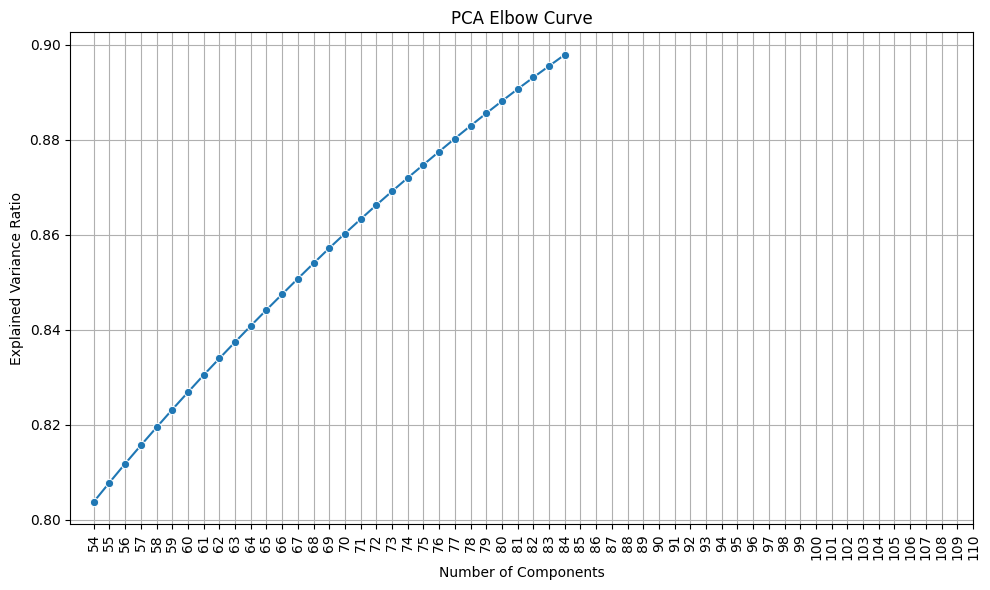

In [109]:
# Plotting Elbow

plt.figure(figsize = (10,6))
sns.lineplot(x="n_components", y="explained_variance_ratio", data = pca_results[(pca_results["explained_variance_ratio"]>0.80) & (pca_results["explained_variance_ratio"] < 0.90)], marker = "o")
plt.title("PCA Elbow Curve")
plt.xlabel("Number of Components")
plt.ylabel("Explained Variance Ratio")
plt.xticks(pca_results["n_components"][(pca_results["explained_variance_ratio"]>0.80) & (pca_results["explained_variance_ratio"] < 0.95)])
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()


#### 85 can be selected as a n_components when doing dimensional reduction since this explains about 85% of the variance

In [110]:
df_scaled.printSchema()

root
 |-- cik: string (nullable = false)
 |-- filename: string (nullable = false)
 |-- year: string (nullable = false)
 |-- section_name: string (nullable = true)
 |-- chunk_id: string (nullable = true)
 |-- embedding: array (nullable = false)
 |    |-- element: float (containsNull = false)
 |-- chunk: string (nullable = true)
 |-- embeddings_vector: vector (nullable = true)
 |-- scaled_vector: vector (nullable = true)



In [111]:
k = 85
pca_85 = PCA(k = k, inputCol = "scaled_vector", outputCol = "pca_features")
pca_model_85 = pca_85.fit(df_scaled)

In [112]:
df_pca_85 = pca_model_85.transform(df_scaled)

In [113]:
df_pca_85.printSchema()

root
 |-- cik: string (nullable = false)
 |-- filename: string (nullable = false)
 |-- year: string (nullable = false)
 |-- section_name: string (nullable = true)
 |-- chunk_id: string (nullable = true)
 |-- embedding: array (nullable = false)
 |    |-- element: float (containsNull = false)
 |-- chunk: string (nullable = true)
 |-- embeddings_vector: vector (nullable = true)
 |-- scaled_vector: vector (nullable = true)
 |-- pca_features: vector (nullable = true)



In [114]:
df_pca_85.show()

+------+---------------+----+------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|   cik|       filename|year|section_name|            chunk_id|           embedding|               chunk|   embeddings_vector|       scaled_vector|        pca_features|
+------+---------------+----+------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|718413|718413_2020.htm|2020|   section_1|9cd495a9-179c-450...|[-0.00838658, 0.0...|Item 1. The Busin...|[-0.0083865802735...|[-0.9072808082209...|[0.28796903479624...|
|718413|718413_2020.htm|2020|   section_1|ec13d719-ad18-428...|[-0.0064487373, 0...|currently maintai...|[-0.0064487373456...|[-0.8353105320367...|[1.57690375079934...|
|718413|718413_2020.htm|2020|   section_1|c63e6ee1-34e4-411...|[0.012929839, -0....|. The Company als...|[0.01292983908206...|[-0.1156023051741...|[1.15590

### Since most of the plotting functions are non-distributed like TSNE, seaborn and Matplotlib - we will need to copy the data frame into pandas and then perform the steps

In [115]:
df_pca_pd = df_pca_85.toPandas()
df_pca_pd.shape

(2109, 10)

In [116]:
pd.reset_option('display.max_colwidth', None) 
df_pca_pd.head(1)

,cik,filename,year,section_name,chunk_id,embedding,chunk,embeddings_vector,scaled_vector,pca_features
0,718413,718413_2020.htm,2020,section_1,9cd495a9-179c-450e-8ada-d8feddb2d69e,"[-0.008386580273509026, 0.00922026764601469, 0...",Item 1. The Business\nOrganization and Operati...,"[-0.008386580273509026, 0.00922026764601469, 0...","[-0.9072808082209509, -0.35620196577784674, 0....","[0.2879690347962443, -2.4314028527981484, -3.7..."


* Optimal value of principal components for deduped dataset is 85 components according to PCA analysis
* Needs 85 + components to explain 90% variance
* Each components adds only 0.03% variance
* No clear elbow
* Embeddings have information spread across many dimensions
* No dominant principal component

In [117]:
scaled_vectors = df_pca_pd["scaled_vector"]

## Dimesnionality Reduction with T-SNE for better visualization

In [118]:
X = np.array(scaled_vectors.tolist())
X.shape

(2109, 768)

In [119]:
tsne = TSNE(random_state = 42)
X_tsne = tsne.fit_transform(X)
df_pca_pd[['tsne_x', 'tsne_y']] = pd.DataFrame(X_tsne.tolist(), index=df_pca_pd.index)


D:\Softwares\Anaconda3\envs\coding_task_venv\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [120]:
df_pca_pd.head(1)

,cik,filename,year,section_name,chunk_id,embedding,chunk,embeddings_vector,scaled_vector,pca_features,tsne_x,tsne_y
0,718413,718413_2020.htm,2020,section_1,9cd495a9-179c-450e-8ada-d8feddb2d69e,"[-0.008386580273509026, 0.00922026764601469, 0...",Item 1. The Business\nOrganization and Operati...,"[-0.008386580273509026, 0.00922026764601469, 0...","[-0.9072808082209509, -0.35620196577784674, 0....","[0.2879690347962443, -2.4314028527981484, -3.7...",4.414322,9.857345


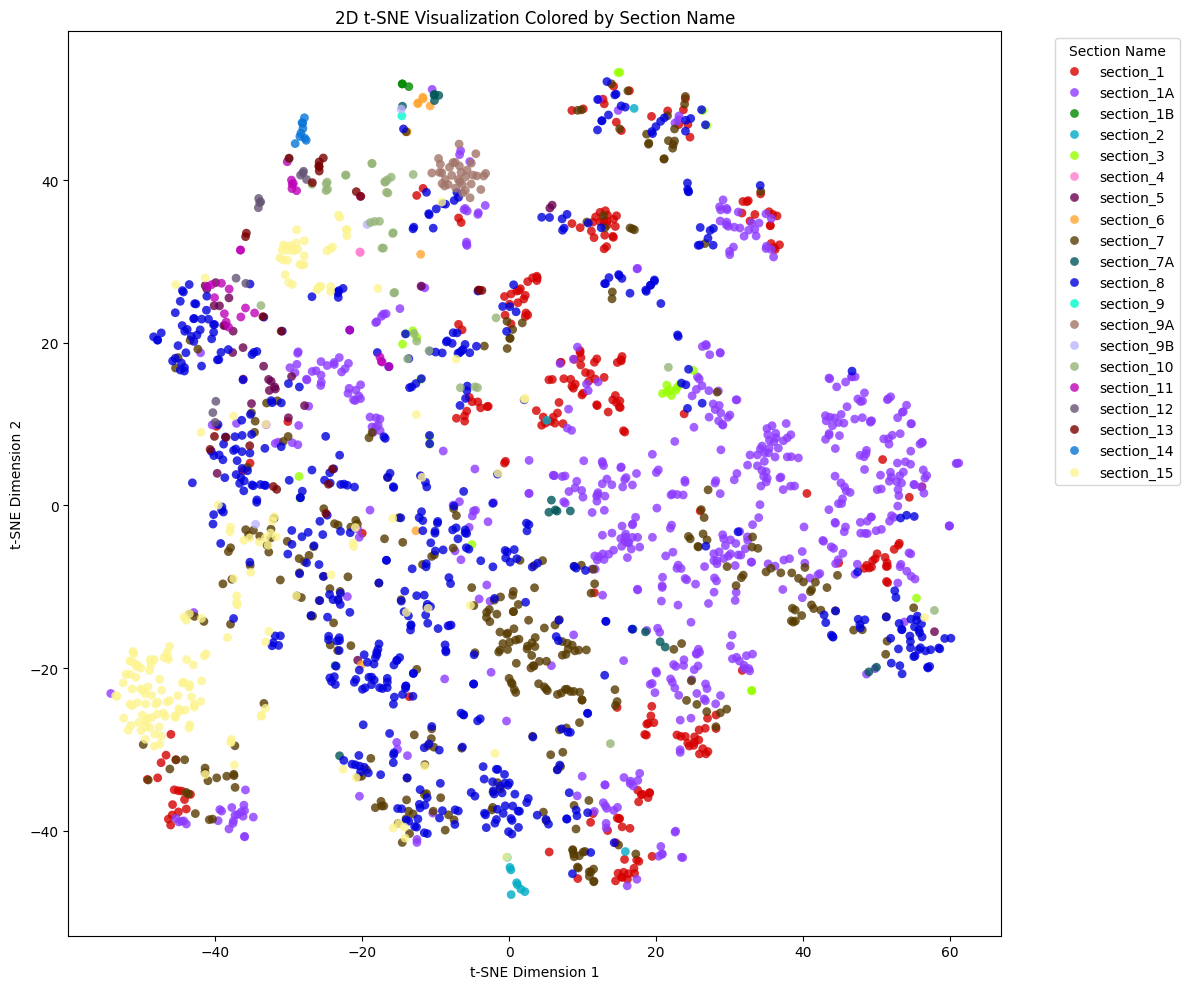

In [121]:
np.random.seed(42)
plt.figure(figsize=(12,10))
base_colors = sns.color_palette("tab20", 20)
extra_colors = [(0.8, 0.2, 0.2), (0.2, 0.6, 0.8), (0.5, 0.5, 0.1)]  # Custom RGB tuples
palette_20 = cc.glasbey[:20]
sns.scatterplot(
    x='tsne_x', y='tsne_y', 
    hue='section_name', 
    palette=palette_20,
    data=df_pca_pd,
    s=40,
    alpha=0.8,
    edgecolor='none'
)

plt.title("2D t-SNE Visualization Colored by Section Name")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title='Section Name', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

* As expected T-SNE visualization shows more distinct clustering than PCA visualization
* There is some clustering by section, but not very tight or completely separated clusters.
* Some sections (e.g., section_1, section_1A, section_7, section_8, section_15) seem to have many points scattered across the plot - diverse topics
* Other sections (e.g., section_9A, section_9B) form smaller, somewhat more distinct groups - standardized vocabulary
* Some overlap between different section clusters is visible, suggesting embeddings from different sections share semantic similarities or are not fully separable in this 2D space - This is because of formal language or legal terminology being used for filings across sections.



In [122]:
pca_features = np.array(df_pca_pd["pca_features"].to_list())
# UMAP reduction
reducer = UMAP(
    n_neighbors=30,
    min_dist=0.1,
    n_components=2,
    random_state=42,
    metric="cosine",
    init="spectral",
)
embedding_2d = reducer.fit_transform(pca_features)

D:\Softwares\Anaconda3\envs\coding_task_venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [123]:
embedding_2d.shape

(2109, 2)

In [124]:
df_pca_pd["umap_x"] = embedding_2d[:, 0]
df_pca_pd["umap_y"] = embedding_2d[:, 1]

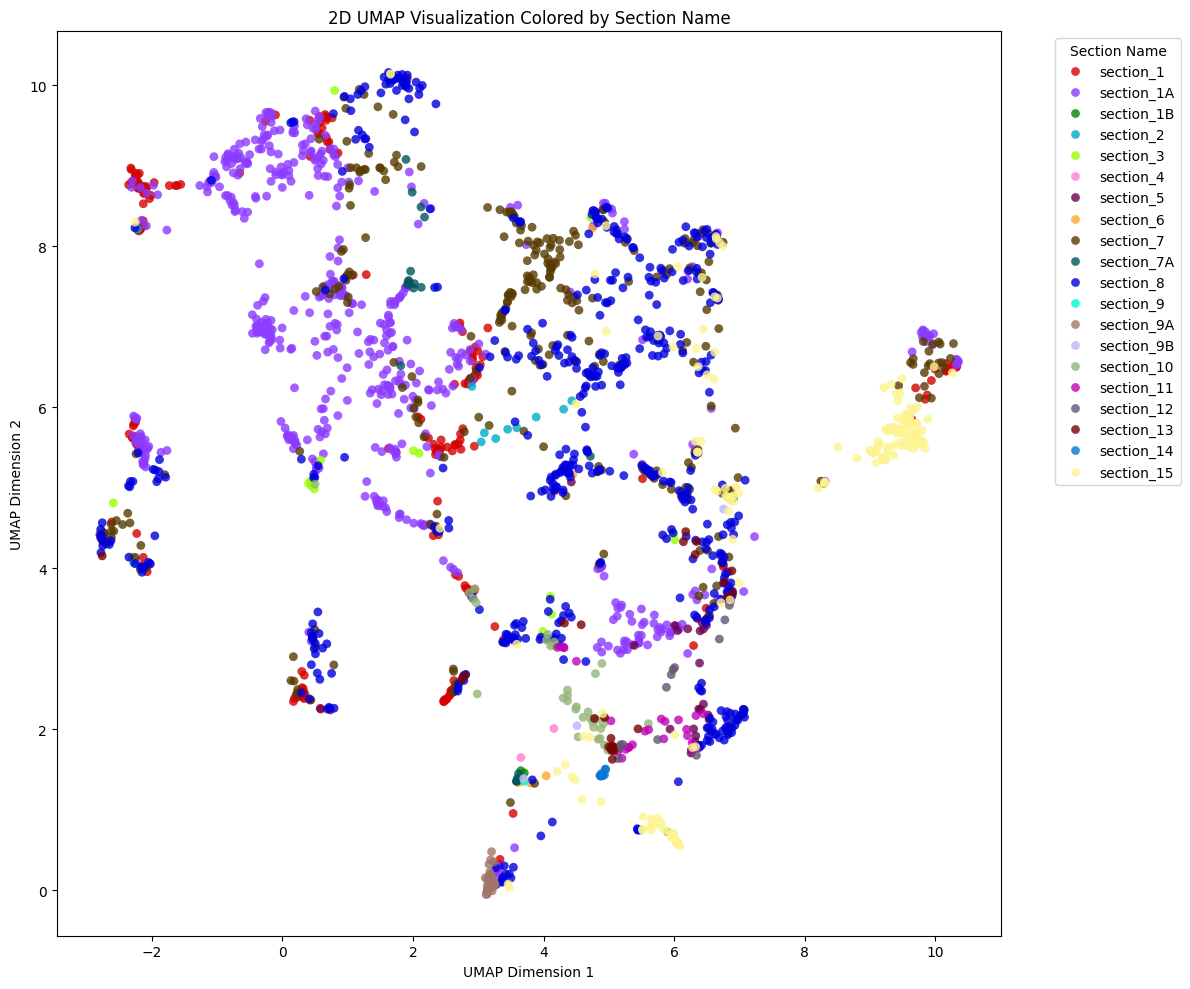

In [125]:
plt.figure(figsize=(12,10))
base_colors = sns.color_palette("tab20", 20)
extra_colors = [(0.8, 0.2, 0.2), (0.2, 0.6, 0.8), (0.5, 0.5, 0.1)]  # Custom RGB tuples
palette_20 = cc.glasbey[:20]
sns.scatterplot(
    x='umap_x', y='umap_y', 
    hue='section_name', 
    palette=palette_20,
    data=df_pca_pd,
    s=40,
    alpha=0.8,
    edgecolor='none'
)

plt.title("2D UMAP Visualization Colored by Section Name")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend(title='Section Name', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

### Comparing the UMAP and t-SNE visualizations of the same SEC 10-K data reveals significant differences:

- UMAP: Tighter, more defined clusters with clear boundaries
- t-SNE: More scattered, diffuse groupings with less distinct separation 
- Each color represents a different 10-K section, and they form well-separated clusters, indicating sections have unique semantic fingerprints
- Section 11 (Executive Compensation), Section 8 (Financial Statements and Supplementary Data): They form large, distributed presence across multiple regions suggests this section has diverse content variations across companies
- Section 9A (Controls and Procedures) forms tight clustering - likely to be standard specific languages
- Section 1 (Business-Company Background) in red forms dispersed tight clusters. Standardized language patterns but define differnent type of backgrounds.
- Section 15 (Exhibit and Financial Statement Schedules) - forms clusters apart from other datapoints showing variation in language comapred to other sections


## Clustering
#### Data will be reduced in dimensionality to 85 components that explains 90% variations

## K-Means Clustering

In [126]:
pca_features = np.array(df_pca_pd["pca_features"].to_list())

In [127]:
# pca_features = pca_features.reshape(-1,1)
pca_features.shape

(2109, 85)

Text(0.5, 1.0, 'Selecting k with Elbow Method')

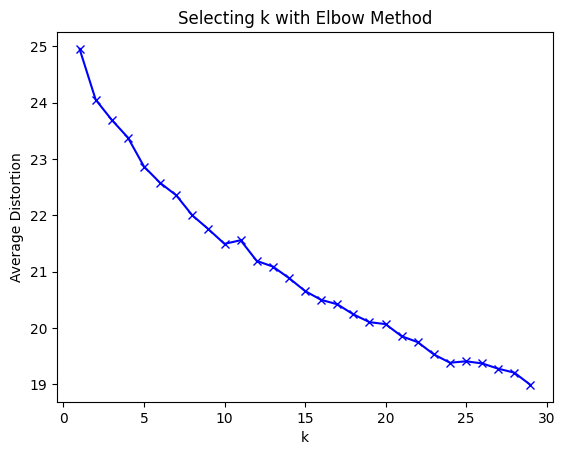

In [128]:
# finding optimal clusters
clusters = range(1,30)
meanDistortions = []

for k in clusters:
    model = KMeans(n_clusters = k)
    model.fit(pca_features)
    prediction = model.predict(pca_features)
    meanDistortions.append(sum(np.min(cdist(pca_features, model.cluster_centers_, 'euclidean'), axis = 1))/pca_features.shape[0])

plt.plot(clusters, meanDistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Average Distortion')
plt.title('Selecting k with Elbow Method')


* There are no clear elbows
* There is an elbow at 10-11 and one at 13.
* To maintain the trade off between compression and accuracy - we can try 13.

For n_clusters = 8, the silhouette score is 0.07613343760578152)
For n_clusters = 9, the silhouette score is 0.07413055023389872)
For n_clusters = 10, the silhouette score is 0.07309783994806422)
For n_clusters = 11, the silhouette score is 0.07676289161530565)
For n_clusters = 12, the silhouette score is 0.07738122497681423)
For n_clusters = 13, the silhouette score is 0.08108094417357374)
For n_clusters = 14, the silhouette score is 0.07955093483621367)


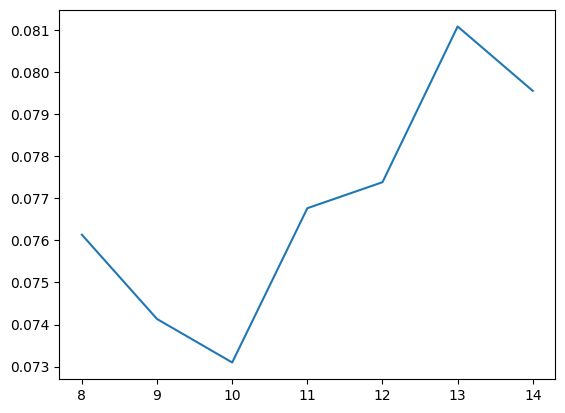

In [129]:
# Calculating Silhouette scores
sil_score = []
cluster_list = list(range(8,15))
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters, random_state = 42)
    preds = clusterer.fit_predict(pca_features)
    # centers = clusterer.cluster_centers_
    score = silhouette_score(pca_features, preds)
    sil_score.append(score)
    print("For n_clusters = {}, the silhouette score is {})".format(n_clusters, score))

plt.plot(cluster_list, sil_score)
plt.show()

* Silhouette Scores are very low shwoing very closely grouped data points or clusters
* 13 clusters seems optimal within the list the perfect tradeoff between compression and accuracy

In [130]:
clusterer = KMeans(13)
preds_13 = clusterer.fit_predict((pca_features))
df_pca_pd["K_means_cluster"] = preds_13

cluster_centers = clusterer.cluster_centers_

In [131]:
pd.reset_option('display.max_colwidth')
df_pca_pd.head()

,cik,filename,year,section_name,chunk_id,embedding,chunk,embeddings_vector,scaled_vector,pca_features,tsne_x,tsne_y,umap_x,umap_y,K_means_cluster
0,718413,718413_2020.htm,2020,section_1,9cd495a9-179c-450e-8ada-d8feddb2d69e,"[-0.008386580273509026, 0.00922026764601469, 0...",Item 1. The Business\nOrganization and Operati...,"[-0.008386580273509026, 0.00922026764601469, 0...","[-0.9072808082209509, -0.35620196577784674, 0....","[0.2879690347962443, -2.4314028527981484, -3.7...",4.414322,9.857345,-2.180445,8.212131,7
1,718413,718413_2020.htm,2020,section_1,ec13d719-ad18-428d-9bb7-e00f2ad5b148,"[-0.006448737345635891, 0.006905729416757822, ...",currently maintains eleven branch offices in n...,"[-0.006448737345635891, 0.006905729416757822, ...","[-0.8353105320367672, -0.41717229462889566, 0....","[1.576903750799345, 0.2433513467044235, -3.704...",5.619185,10.342686,-2.183655,8.198899,7
2,718413,718413_2020.htm,2020,section_1,c63e6ee1-34e4-411f-8719-cd77e4db8b50,"[0.012929839082062244, -0.03554750233888626, -...",. The Company also offers business checking an...,"[0.012929839082062244, -0.03554750233888626, -...","[-0.11560230517419638, -1.5354893170971176, 0....","[1.1559021331286472, 0.529856565575861, -2.622...",5.980703,10.853430,-2.193788,8.232184,7
3,718413,718413_2020.htm,2020,section_1,ada183d8-8e94-45a4-8e40-c1a2b72d27e1,"[0.029037252068519592, -0.019787346944212914, ...","the needs of consumers, including personal loa...","[0.029037252068519592, -0.019787346944212914, ...","[0.4826169542785675, -1.1203301095236118, -0.1...","[2.8212995243985706, -0.01119880465172628, -0....",6.568409,11.364455,-2.130884,8.315777,7
4,718413,718413_2020.htm,2020,section_1,fe63bea6-311d-48ce-92de-49e1c0f227eb,"[0.021866939961910248, -0.006463263183832169, ...",“Management’s Discussion and Analysis of Finan...,"[0.021866939961910248, -0.006463263183832169, ...","[0.21631604040323257, -0.7693427038110849, 1.7...","[-5.915111969799059, -4.028264278837126, -2.57...",4.628221,10.868239,-2.199458,8.218099,7


## Outliers

In [132]:
distances = np.min(cdist(pca_features, clusterer.cluster_centers_, 'euclidean'), axis = 1)
df_pca_pd["distance_to_centroid"] = distances

In [133]:
threshold = distances.mean() + 2 * distances.std()
df_pca_pd["outliers_kmeans"] = distances > threshold
df_pca_pd.head()

,cik,filename,year,section_name,chunk_id,embedding,chunk,embeddings_vector,scaled_vector,pca_features,tsne_x,tsne_y,umap_x,umap_y,K_means_cluster,distance_to_centroid,outliers_kmeans
0,718413,718413_2020.htm,2020,section_1,9cd495a9-179c-450e-8ada-d8feddb2d69e,"[-0.008386580273509026, 0.00922026764601469, 0...",Item 1. The Business\nOrganization and Operati...,"[-0.008386580273509026, 0.00922026764601469, 0...","[-0.9072808082209509, -0.35620196577784674, 0....","[0.2879690347962443, -2.4314028527981484, -3.7...",4.414322,9.857345,-2.180445,8.212131,7,23.537929,False
1,718413,718413_2020.htm,2020,section_1,ec13d719-ad18-428d-9bb7-e00f2ad5b148,"[-0.006448737345635891, 0.006905729416757822, ...",currently maintains eleven branch offices in n...,"[-0.006448737345635891, 0.006905729416757822, ...","[-0.8353105320367672, -0.41717229462889566, 0....","[1.576903750799345, 0.2433513467044235, -3.704...",5.619185,10.342686,-2.183655,8.198899,7,23.246552,False
2,718413,718413_2020.htm,2020,section_1,c63e6ee1-34e4-411f-8719-cd77e4db8b50,"[0.012929839082062244, -0.03554750233888626, -...",. The Company also offers business checking an...,"[0.012929839082062244, -0.03554750233888626, -...","[-0.11560230517419638, -1.5354893170971176, 0....","[1.1559021331286472, 0.529856565575861, -2.622...",5.980703,10.853430,-2.193788,8.232184,7,21.679364,False
3,718413,718413_2020.htm,2020,section_1,ada183d8-8e94-45a4-8e40-c1a2b72d27e1,"[0.029037252068519592, -0.019787346944212914, ...","the needs of consumers, including personal loa...","[0.029037252068519592, -0.019787346944212914, ...","[0.4826169542785675, -1.1203301095236118, -0.1...","[2.8212995243985706, -0.01119880465172628, -0....",6.568409,11.364455,-2.130884,8.315777,7,18.848032,False
4,718413,718413_2020.htm,2020,section_1,fe63bea6-311d-48ce-92de-49e1c0f227eb,"[0.021866939961910248, -0.006463263183832169, ...",“Management’s Discussion and Analysis of Finan...,"[0.021866939961910248, -0.006463263183832169, ...","[0.21631604040323257, -0.7693427038110849, 1.7...","[-5.915111969799059, -4.028264278837126, -2.57...",4.628221,10.868239,-2.199458,8.218099,7,20.764423,False


In [134]:
outliers_df = df_pca_pd[df_pca_pd["outliers_kmeans"]]
outlier_summary = outliers_df.groupby(['cik', 'section_name']).size().reset_index(name='count')
print(f"Total outliers: {len(outliers_df)}")
print("\nOutliers by company and section:")
outlier_summary

Total outliers: 49

Outliers by company and section:


,cik,section_name,count
0,1282224,section_1,1
1,1282224,section_1A,1
2,1282224,section_1B,1
3,1282224,section_6,1
4,1282224,section_7,1
5,1282224,section_7A,1
6,1490873,section_1,4
7,1490873,section_10,1
8,1490873,section_13,1
9,1490873,section_3,1


In [135]:
outlier_summary = outliers_df.groupby(['section_name']).size().reset_index(name='count')
print(f"Total outliers: {len(outliers_df)}")
print("\nOutliers by company and section:")
outlier_summary

Total outliers: 49

Outliers by company and section:


,section_name,count
0,section_1,7
1,section_10,3
2,section_13,1
3,section_1A,21
4,section_1B,2
5,section_2,2
6,section_3,1
7,section_4,1
8,section_6,2
9,section_7,4


Looking at these outliers from 10-K analysis, several patterns emerge:

### Key Outlier Patterns

• Company concentration**: Most outliers come from 2 companies (CIKs: 1490873, 1559720)

• Section distribution: Heavy concentration in sections 1, 1A, and 7A:
  - Section 1A (Risk Factors): 21 instances
  - Section 1 (Business/Company Background): 7 instances

## Recommended Analysis

-Manual review: Examine actual text from CIK 1559720, 1490873 sections to identify specific language differences

-These outliers likely represent legitimate business complexity rather than data errors.

In [136]:
pd.set_option('display.max_colwidth', None)
df_pca_pd[df_pca_pd["K_means_cluster"] == 0]["chunk"].head(1)

243    Item 1A. Risk Factors\nBefore deciding to invest in the Company or to maintain or increase an investment, investors should carefully consider the material risks and uncertainties described below that could negatively affect our business, financial condition or results of operations. The risks and uncertainties described below and in the Company’s other filings with the SEC are not the only ones the Company faces. Additional risks and uncertainties not presently known to management or that are currently deemed immaterial may emerge or evolve and also affect the Company’s business. If any of these known or unknown risks or uncertainties actually occurs, the Company’s business, financial condition and results of operations could be adversely affected, which in turn could result in a decline in the value of the Company’s capital stock.\nECOMONIC AND OTHER EXTERNAL RISKS\nThe COVID-19 pandemic is disruptive to us and our customers, employees and third-party service providers, and the

In [137]:
df_pca_pd[df_pca_pd["K_means_cluster"] == 0]["chunk"].tail(1)

1836    directing the Company and all individual defendants to take all necessary actions to reform and improve the Company's corporate governance in order to avoid any alleged future harm to the Company.
Name: chunk, dtype: object

- Both parts bear semantic similarity

In [138]:
df_section_clusters = df_pca_pd.groupby("section_name")["K_means_cluster"].nunique().reset_index(name="num_clusters")
df_section_clusters


,section_name,num_clusters
0,section_1,11
1,section_10,4
2,section_11,3
3,section_12,2
4,section_13,3
5,section_14,2
6,section_15,9
7,section_1A,13
8,section_1B,1
9,section_2,5


* As interpreted from diagram section_1, section_15, section_1A, section_7 and section_8 are the most diverese and nearly represented in all clusters
* Others are more or less in smaller number of clusters
* 13 seems to be agood trade-off between accuracy and compression

### Plots

#### Colored by clusters

In [139]:
df_pca_pd["K_means_cluster"].nunique()

13

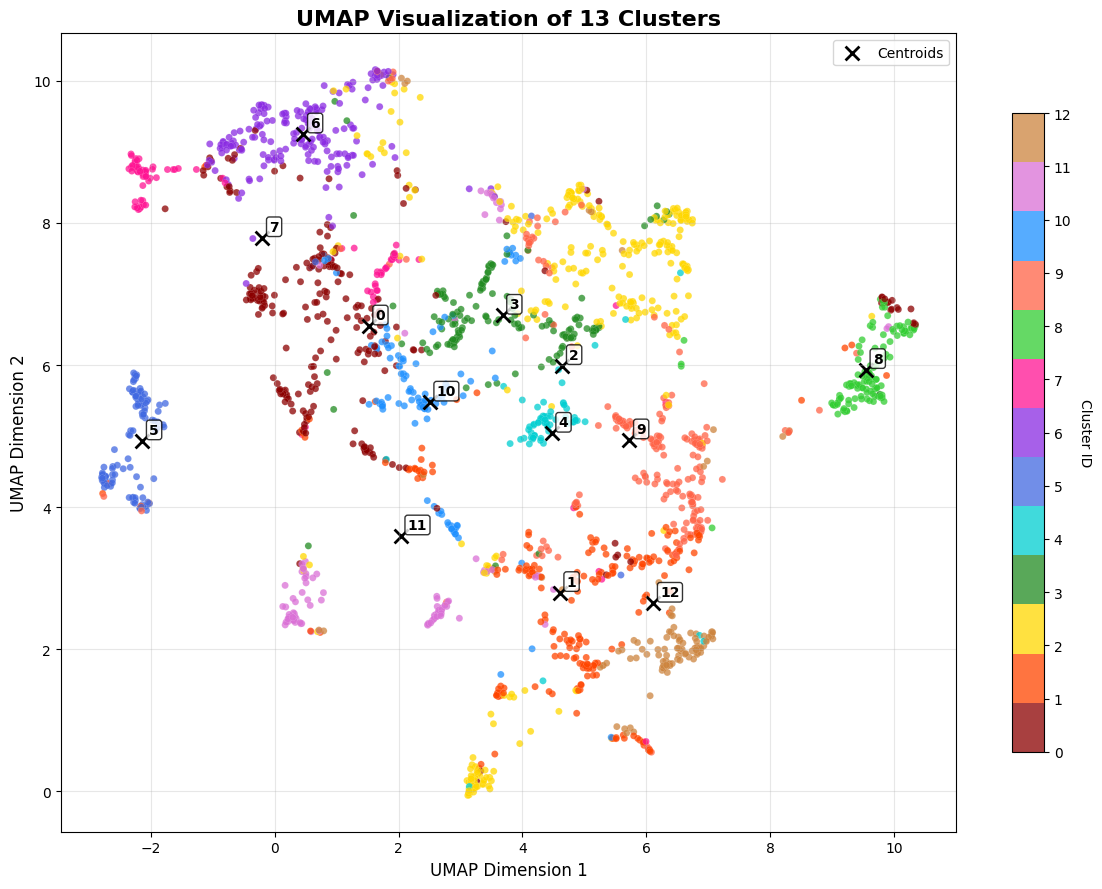

In [140]:
# Create figure with better proportions
plt.figure(figsize=(12, 9))

# Define custom deep, distinct colors for 13 clusters
colors = ['#8B0000', '#FF4500', '#FFD700', '#228B22', '#00CED1', 
          '#4169E1', '#8A2BE2', '#FF1493', '#32CD32', '#FF6347',
          '#1E90FF', '#DA70D6', '#CD853F']
cmap = plt.matplotlib.colors.ListedColormap(colors)

# Create scatter plot
scatter = plt.scatter(df_pca_pd["umap_x"],
                     df_pca_pd["umap_y"],
                     c=df_pca_pd["K_means_cluster"],
                     cmap=cmap, 
                     s=25,  # Slightly larger points
                     alpha=0.75,
                     edgecolors='white',  # Add white borders for better separation
                     linewidth=0.1)

# Improve colorbar
cbar = plt.colorbar(scatter, shrink=0.8)
cbar.set_label('Cluster ID', rotation=270, labelpad=15)
cbar.set_ticks(range(13))  # Ensure all cluster numbers show

# Add cluster centroids with index labels
cluster_centers = df_pca_pd.groupby('K_means_cluster')[['umap_x', 'umap_y']].mean()
plt.scatter(cluster_centers['umap_x'], cluster_centers['umap_y'], 
           c='black', marker='x', s=100, linewidth=2, label='Centroids')

# Add cluster index labels next to centroids
for cluster_id, (x, y) in cluster_centers.iterrows():
    plt.annotate(f'{cluster_id}', (x, y), xytext=(5, 5), 
                textcoords='offset points', fontsize=10, fontweight='bold',
                color='black', bbox=dict(boxstyle='round,pad=0.2', 
                facecolor='white', alpha=0.8))

# Styling improvements
plt.title("UMAP Visualization of 13 Clusters", fontsize=16, fontweight='bold')
plt.xlabel("UMAP Dimension 1", fontsize=12)
plt.ylabel("UMAP Dimension 2", fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Save with high quality
plt.savefig("clusters.jpeg", dpi=300, bbox_inches='tight', 
           facecolor='white', edgecolor='none')
plt.show()

#### Colored by outliers

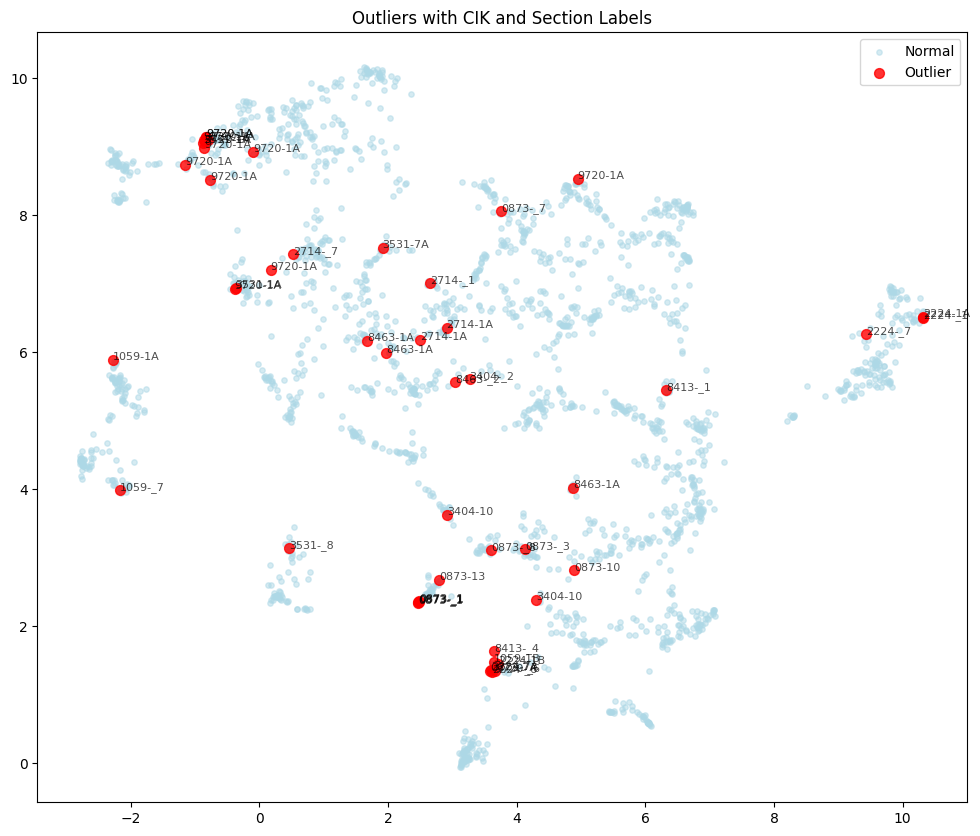

In [141]:
plt.figure(figsize=(12, 10))
# Plot non-outliers
non_outliers = df_pca_pd[~df_pca_pd["outliers_kmeans"]]
plt.scatter(non_outliers["umap_x"], non_outliers["umap_y"], 
           c='lightblue', s=15, alpha=0.5, label='Normal')

# Plot outliers with annotations
outliers = df_pca_pd[df_pca_pd["outliers_kmeans"]]
plt.scatter(outliers["umap_x"], outliers["umap_y"], 
           c='red', s=50, alpha=0.8, label='Outlier')

# Add text labels for outliers
for idx, row in outliers.iterrows():
    plt.annotate(f"{row['cik'][-4:]}-{row['section_name'][-2:]}", 
                (row["umap_x"], row["umap_y"]), 
                fontsize=8, alpha=0.7)

plt.legend()
plt.title("Outliers with CIK and Section Labels")
plt.savefig("outliers_labeled.jpeg", dpi=300, bbox_inches='tight')

#### Colored by Section

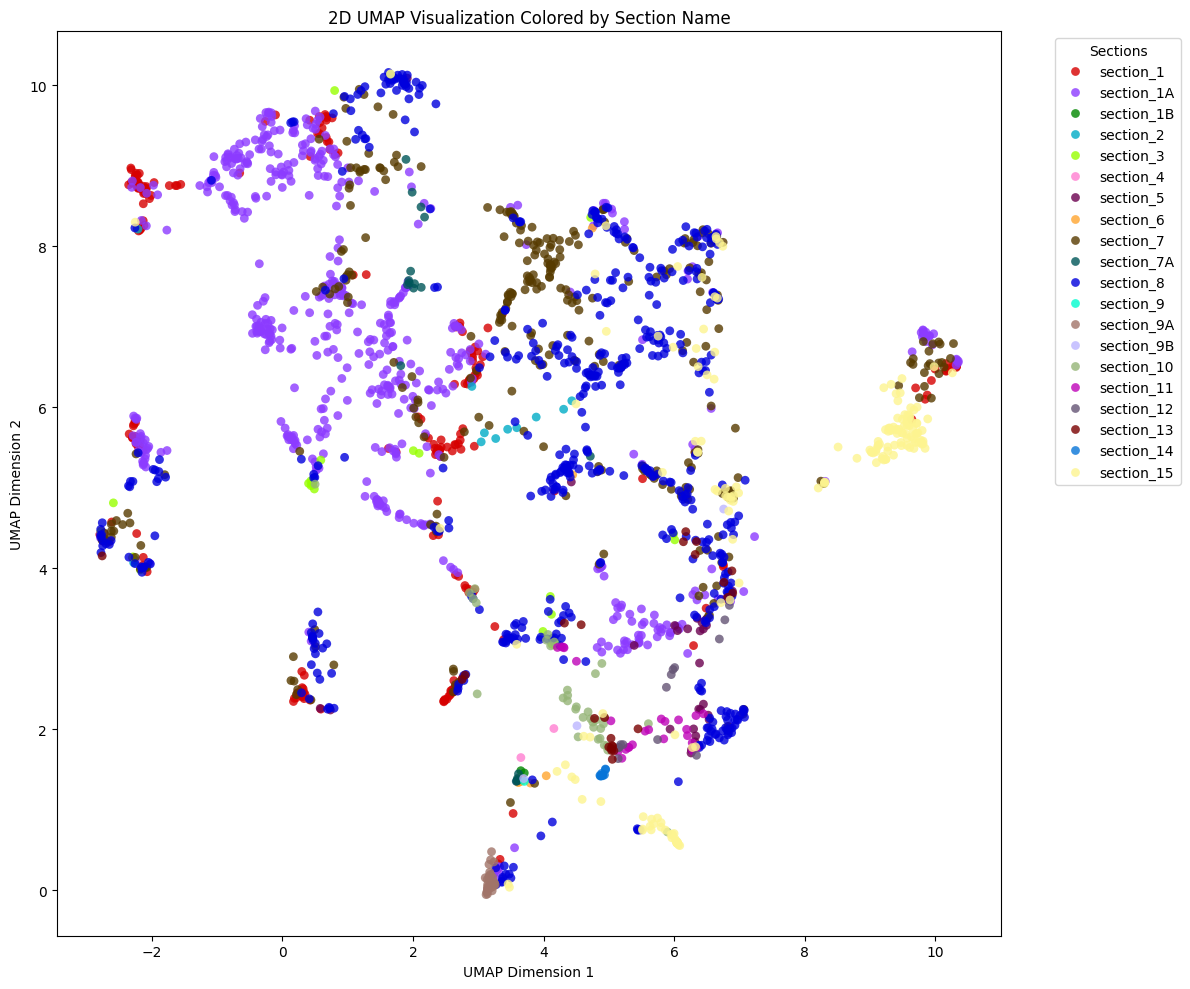

In [142]:
plt.figure(figsize=(12,10))
palette_20 = cc.glasbey[:20]
sns.scatterplot(
    x='umap_x', y='umap_y', 
    hue='section_name', 
    palette=palette_20,
    data=df_pca_pd,
    s=40,
    alpha=0.8,
    edgecolor='none'
)

plt.title("2D UMAP Visualization Colored by Section Name")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend(title='Sections', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.savefig("sections.jpeg", dpi=300, bbox_inches='tight')
plt.show()


### Summary Statistics

In [143]:
# Summary statistics table
summary_stats = pd.DataFrame({
   'Total Chunks': [len(df_pca_pd)],
   'Total Outliers': [df_pca_pd['outliers_kmeans'].sum()],
   'Outlier %': [df_pca_pd['outliers_kmeans'].mean() * 100],
   'Unique Companies': [df_pca_pd['cik'].nunique()],
   'Unique Sections': [df_pca_pd['section_name'].nunique()],
   'Avg Chunk Length': [df_pca_pd['chunk'].str.len().mean()],
   'K-means Clusters': [df_pca_pd['K_means_cluster'].nunique()],
})

# Outliers by company
outliers_by_company = df_pca_pd[df_pca_pd['outliers_kmeans']].groupby('cik').size()
outliers_by_company = outliers_by_company.sort_values(ascending=False)

# Outliers by section
outliers_by_section = df_pca_pd[df_pca_pd['outliers_kmeans']].groupby('section_name').size()
outliers_by_section = outliers_by_section.sort_values(ascending=False)

print("Summary Statistics:")
print(summary_stats.T)
print("\nTop 5 Companies with Most Outliers:")
print(outliers_by_company.head())
print("\nTop 5 Sections with Most Outliers:")
print(outliers_by_section.head())

# Save to CSV
summary_stats.to_csv("summary_statistics.csv", index=False)

Summary Statistics:
                            0
Total Chunks      2109.000000
Total Outliers      49.000000
Outlier %            2.323376
Unique Companies    10.000000
Unique Sections     20.000000
Avg Chunk Length  1528.432432
K-means Clusters    13.000000

Top 5 Companies with Most Outliers:
cik
1559720    13
1490873    10
1282224     6
1678463     4
723531      4
dtype: int64

Top 5 Sections with Most Outliers:
section_name
section_1A    21
section_1      7
section_7      4
section_10     3
section_7A     3
dtype: int64


### UMAP visualizations

- Each color represents a different 10-K section, and they form well-separated clusters, indicating sections have unique semantic fingerprints
- Section 11 (Executive Compensation), Section 8 (Financial Statements and Supplementary Data): They form large, distributed presence across multiple regions suggests this section has diverse content variations across companies
- Section 9A (Controls and Procedures) forms tight clustering - likely to be standard specific languages
- Section 1 (Business-Company Background) in red forms dispersed tight clusters. Standardized language patterns but define differnent type of backgrounds.
- Section 15 (Exhibit and Financial Statement Schedules) - forms clusters apart from other datapoints showing variation in language comapred to other sections

### Cluster investigation
- small satellite clusters or islands which might correspond to niche topics or companies/sections with distinctive phrasing (cluster 8, cluster 5 and cluster 6)
- Overlap/blending between clusters such as cluster 2, 3, 4 and 9 in transitional regions suggests semantic topics that share vocabulary
- Some clusters like cluster 11 and cluster 12 sit apart - might have distinct themes.
- Next steps - Find top keywords/Automatic cluster labeling

### Outlier Investigation

- Outliers are spread across the embedding space but tend to cluster in certain local neighborhoods, not uniformly random—suggesting they are semantically coherent “rare” or distinctive chunks rather than pure noise.
- Some outliers - 0873-1,0873-13, 9720-1A, 2224-1, 2224-7 - appear as small tight groups—likely repeated or highly domain-specific language
- There are isolated outliers like 1059-7,1059-1A, 2224-1 and 2224-7 which may represent genuinely anomalous content—could be footnotes, restatements, or rare one-off disclosures.
- Some clusters of outliers overlap with dense normal points, indicating borderline cases where language is similar to common content but has enough distinctiveness to be flagged as outliers like 8463-1A
- Next step - Raw chunk text and section context/Drift analysis in future


## Next Steps

### Cluster Analysis

In [144]:
# Get top 5 representative chunks per cluster (closest to centroid)
top_5_per_cluster = df_pca_pd.groupby('K_means_cluster').apply(lambda x: x.nsmallest(5, 'distance_to_centroid')).reset_index(drop=True)

C:\Users\akash\AppData\Local\Temp\ipykernel_7120\2037571560.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_5_per_cluster = df_pca_pd.groupby('K_means_cluster').apply(lambda x: x.nsmallest(5, 'distance_to_centroid')).reset_index(drop=True)


In [145]:
pd.reset_option('display.max_colwidth', None)
top_5_per_cluster.head(1)

,cik,filename,year,section_name,chunk_id,embedding,chunk,embeddings_vector,scaled_vector,pca_features,tsne_x,tsne_y,umap_x,umap_y,K_means_cluster,distance_to_centroid,outliers_kmeans
0,1559720,1559720_2020.htm,2020,section_1A,25c36f3e-1e4a-4f6f-842c-56fe1cba0ec0,"[-0.017618127167224884, 0.04670749232172966, -...","or severity of incidents increases, our insura...","[-0.017618127167224884, 0.04670749232172966, -...","[-1.2501346948758294, 0.6312988615147488, -0.5...","[12.534840242289764, -6.66819536042238, 8.4541...",30.975264,3.931183,0.129614,6.719017,0,15.907552,False


In [146]:
# Extract top keywords per cluster using TF-IDF
def extract_top_keywords(cluster_texts, n_keywords=10):
    # Custom stop words to remove generic business terms
    custom_stops = ['company', 'million', 'january', 'february', 'march', 'april', 
                   'may', 'june', 'july', 'august', 'september', 'october', 
                   'november', 'december', 'year', 'years', 'business', 'inc',
                   'corporation', 'corp', 'ltd', 'llc']
    
    vectorizer = TfidfVectorizer(
        max_features=1000, 
        stop_words=list(TfidfVectorizer(stop_words='english').get_stop_words()) + custom_stops,
        ngram_range=(1,2),
        min_df=2,
        token_pattern=r'(?u)\b[a-zA-Z][a-zA-Z]+\b'  # Remove numbers
    )
    tfidf_matrix = vectorizer.fit_transform(cluster_texts)
    feature_names = vectorizer.get_feature_names_out()
    scores = tfidf_matrix.sum(axis=0).A1
    keyword_scores = list(zip(feature_names, scores))
    return sorted(keyword_scores, key=lambda x: x[1], reverse=True)[:n_keywords]

In [147]:
# Generate cluster labels and keywords
cluster_info = {}
for cluster in sorted(df_pca_pd['K_means_cluster'].unique()):
    cluster_data = df_pca_pd[df_pca_pd['K_means_cluster'] == cluster]
    
    # Get top keywords
    texts = cluster_data['chunk'].tolist()
    keywords = extract_top_keywords(texts, 10)
    
    # Auto-generate cluster label from top keywords
    top_words = [kw[0] for kw in keywords[:5]]
    cluster_label = " + ".join(top_words).title()
    
    cluster_info[int(cluster)] = {
        'label': cluster_label,
        'keywords': keywords,
        'size': len(cluster_data)
    }

In [148]:
cluster_info

{0: {'label': 'Financial + Operations + Results + Adverse + Material',
  'keywords': [('financial', np.float64(11.990600282631815)),
   ('operations', np.float64(11.773818179914832)),
   ('results', np.float64(10.734197947300336)),
   ('adverse', np.float64(9.022504830165627)),
   ('material', np.float64(8.951650923850762)),
   ('adversely', np.float64(8.840082146234254)),
   ('condition', np.float64(8.82180267831568)),
   ('results operations', np.float64(8.717467387931999)),
   ('financial condition', np.float64(8.617288617942826)),
   ('material adverse', np.float64(7.64284872064107))],
  'size': 245},
 1: {'label': 'Item + Stock + Common + Common Stock + Shares',
  'keywords': [('item', np.float64(17.471708311557766)),
   ('stock', np.float64(17.003130581914473)),
   ('common', np.float64(12.723827624850072)),
   ('common stock', np.float64(11.775422597260917)),
   ('shares', np.float64(9.163508097864268)),
   ('merger', np.float64(7.391773951920061)),
   ('directors', np.float64(7

In [149]:
# Create cluster summary DataFrame
cluster_summary = pd.DataFrame([
    {
        'Cluster': cluster,
        'Label': info['label'], 
        'Size': info['size'],
        'Top_Keywords': ', '.join([kw[0] for kw in info['keywords'][:5]])
    }
    for cluster, info in cluster_info.items()
])

In [150]:
cluster_summary

,Cluster,Label,Size,Top_Keywords
0,0,Financial + Operations + Results + Adverse + M...,245,"financial, operations, results, adverse, material"
1,1,Item + Stock + Common + Common Stock + Shares,233,"item, stock, common, common stock, shares"
2,2,Tax + Financial + Value + Reporting + Assets,320,"tax, financial, value, reporting, assets"
3,3,Lease + Rental + Equipment + Leases + Sales,159,"lease, rental, equipment, leases, sales"
4,4,Financial + Tax + Consolidated + Term + Merger,63,"financial, tax, consolidated, term, merger"
5,5,Hospital + Operations + Services + Healthcare ...,119,"hospital, operations, services, healthcare, care"
6,6,Hosts + Guests + Platform + Laws + Hosts Guests,192,"hosts, guests, platform, laws, hosts guests"
7,7,Bank + Capital + Financial + Credit + Act,101,"bank, capital, financial, credit, act"
8,8,Marketing + Stock + Consolidated + Common + Co...,122,"marketing, stock, consolidated, common, common..."
9,9,Stock + Preferred + Preferred Stock + Series +...,225,"stock, preferred, preferred stock, series, notes"


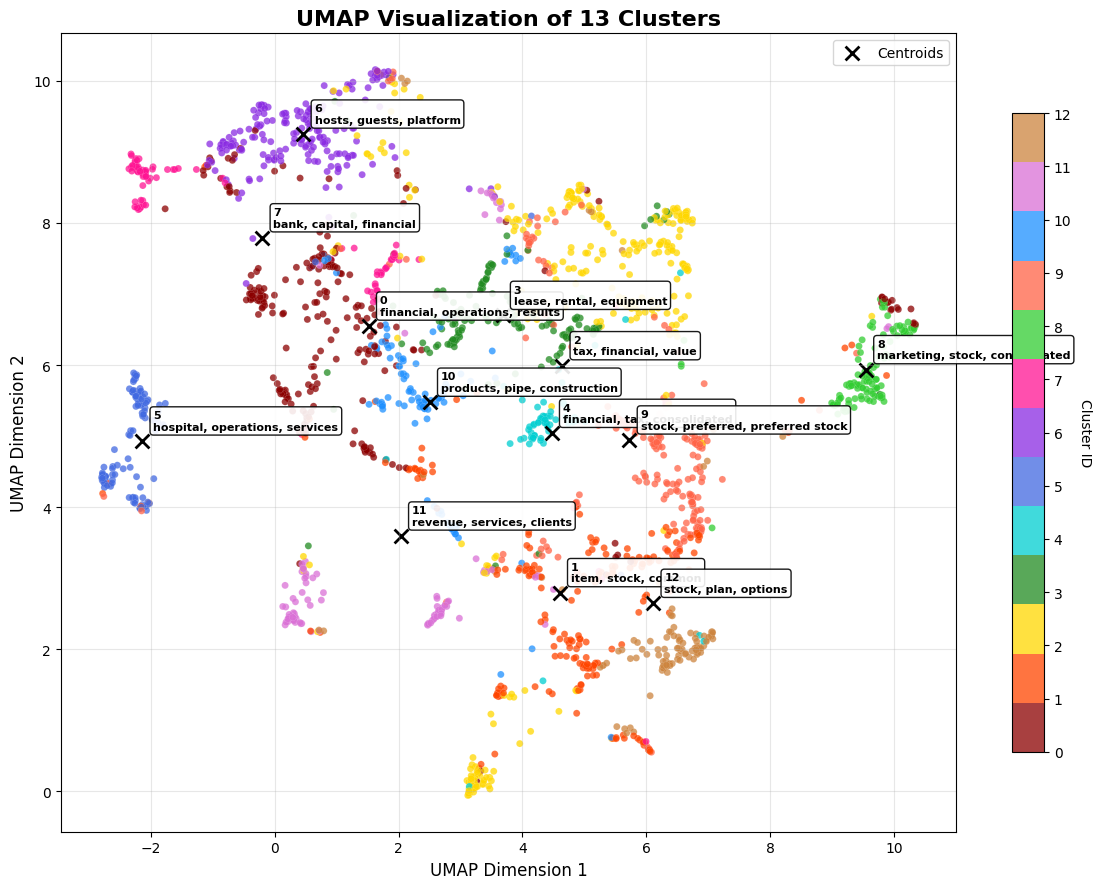

In [151]:
# Create figure with better proportions
plt.figure(figsize=(12, 9))

# Define custom deep, distinct colors for 13 clusters
colors = ['#8B0000', '#FF4500', '#FFD700', '#228B22', '#00CED1', 
          '#4169E1', '#8A2BE2', '#FF1493', '#32CD32', '#FF6347',
          '#1E90FF', '#DA70D6', '#CD853F']
cmap = plt.matplotlib.colors.ListedColormap(colors)

# Create scatter plot
scatter = plt.scatter(df_pca_pd["umap_x"],
                     df_pca_pd["umap_y"],
                     c=df_pca_pd["K_means_cluster"],
                     cmap=cmap, 
                     s=25,  # Slightly larger points
                     alpha=0.75,
                     edgecolors='white',  # Add white borders for better separation
                     linewidth=0.1)

# Improve colorbar
cbar = plt.colorbar(scatter, shrink=0.8)
cbar.set_label('Cluster ID', rotation=270, labelpad=15)
cbar.set_ticks(range(13))  # Ensure all cluster numbers show

# Add cluster centroids with index labels and top keywords
cluster_centers = df_pca_pd.groupby('K_means_cluster')[['umap_x', 'umap_y']].mean()
plt.scatter(cluster_centers['umap_x'], cluster_centers['umap_y'], 
           c='black', marker='x', s=100, linewidth=2, label='Centroids')

# Add cluster index and top keywords as labels
for cluster_id, (x, y) in cluster_centers.iterrows():
    # Get top keywords for this cluster
    keywords = cluster_summary[cluster_summary['Cluster'] == cluster_id]['Top_Keywords'].iloc[0]
    top_3_keywords = ', '.join(keywords.split(', ')[:3])  # First 3 keywords
    
    label_text = f'{cluster_id}\n{top_3_keywords}'
    plt.annotate(label_text, (x, y), xytext=(8, 8), 
                textcoords='offset points', fontsize=8, fontweight='bold',
                color='black', bbox=dict(boxstyle='round,pad=0.3', 
                facecolor='white', alpha=0.9), ha='left')

# Styling improvements
plt.title("UMAP Visualization of 13 Clusters", fontsize=16, fontweight='bold')
plt.xlabel("UMAP Dimension 1", fontsize=12)
plt.ylabel("UMAP Dimension 2", fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Save with high quality
plt.savefig("clusters_with_labels.jpeg", dpi=300, bbox_inches='tight', 
           facecolor='white', edgecolor='none')
plt.show()

### Outlier Analysis

In [152]:
#Extract keywords from outliers
def extract_outlier_keywords(texts, n_keywords=15):
    custom_stops = ['company', 'million', 'january', 'february', 'march', 'april', 
                   'may', 'june', 'july', 'august', 'september', 'october', 
                   'november', 'december', 'year', 'years', 'business', 'inc',
                   'corporation', 'corp', 'ltd', 'llc']
    
    vectorizer = TfidfVectorizer(
        max_features=500, 
        stop_words=list(TfidfVectorizer(stop_words='english').get_stop_words()) + custom_stops,
        ngram_range=(1,2),
        min_df=1,
        token_pattern=r'(?u)\b[a-zA-Z][a-zA-Z]+\b'
    )
    tfidf_matrix = vectorizer.fit_transform(texts)
    feature_names = vectorizer.get_feature_names_out()
    scores = tfidf_matrix.sum(axis=0).A1
    return sorted(zip(feature_names, scores), key=lambda x: x[1], reverse=True)[:n_keywords]

In [153]:
# Overall outlier keywords
outliers = df_pca_pd[df_pca_pd['outliers_kmeans'] == True]
outlier_keywords = extract_outlier_keywords(outliers['chunk'].tolist())

In [154]:
outlier_keywords

[('item', np.float64(5.888088029481008)),
 ('data', np.float64(2.817721674654401)),
 ('required', np.float64(1.6819304994110964)),
 ('federal', np.float64(1.6364413184368256)),
 ('laws', np.float64(1.6209725097508185)),
 ('state', np.float64(1.6089327292851694)),
 ('information', np.float64(1.5697562710700828)),
 ('personal', np.float64(1.5474083854142715)),
 ('financial', np.float64(1.4388802749834473)),
 ('risk', np.float64(1.4130251442030075)),
 ('regulations', np.float64(1.3175056757158794)),
 ('including', np.float64(1.3084165036891804)),
 ('tax', np.float64(1.305673384478592)),
 ('parties', np.float64(1.2968296695319514)),
 ('privacy', np.float64(1.2848739561999667))]

### Cluster Analysis
0. **Financial Operations** (245 chunks) - financial, operations, results, adverse, material
1. **Common Stock** (233 chunks) - item, stock, common, common stock, shares  
2. **Tax & Assets** (320 chunks) - tax, financial, value, reporting, assets
3. **Leasing** (159 chunks) - lease, rental, equipment, leases, sales
4. **Mergers & Tax** (63 chunks) - financial, tax, consolidated, term, merger
5. **Healthcare** (119 chunks) - hospital, operations, services, healthcare, care
6. **Platform/Tech** (192 chunks) - hosts, guests, platform, laws, hosts guests
7. **Banking** (101 chunks) - bank, capital, financial, credit, act
8. **Marketing** (122 chunks) - marketing, stock, consolidated, common
9. **Preferred Stock** (225 chunks) - stock, preferred, preferred stock, series, notes
10. **Construction** (113 chunks) - products, pipe, construction, water, financial
11. **Revenue Services** (110 chunks) - revenue, services, clients, fiscal, insurance
12. **Stock Options** (107 chunks) - stock, plan, options, based, shares

### Clustering Quality
- Distinct spatial separation between clusters
- Keywords are domain-specific and meaningful
- Healtchare cluster (5), Technology cluster (6) and Marketing cluster (8) properly separated from financial clusters in it's own area
- Financial topics (0,2), (4,9) cluster in similar regions